In [1]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytime
import statsmodels.tsa.stattools as tsa
import ruptures as rpt
sys.path.append('../../..')
import InsanallyLabEphysTools as ilep
#import OldDecodingTools as odt
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model
from itertools import product
from datetime import datetime
from matplotlib.backends.backend_pdf import PdfPages
import h5py
#import tables as tb
from copy import deepcopy
import colorsys
import pingouin as pg

from sklearn.model_selection import GridSearchCV, StratifiedKFold, LeaveOneOut
from sklearn.neighbors import KernelDensity

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.weight'] = 'light'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'
GOOD_GREY = '#969696'
GOOD_GREEN = '#32A852'
SWITCH_COLOR = '#B07A3B'
NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NCR_COLOR, CR_COLOR], N=1000)
PHASE_COLORS = ['#E2CAE3','#C27AC5','#764979','#B9D3F7','#5181C2','#3C557A']
TARGET_COLOR = '#109747'
NONTARGET_COLOR = 'black'

act_directory = 'D:\\Analysis_Cache_M2_300'#'C:\\Users\insan\\Desktop\\Analysis_Cache_Aug23'
beh_directory = 'Z:\\Behavioor'

animals = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19']
#animals = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108']
BS_animal_M2 = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108']

stdfont = 14
stdyfrac = 0.06

C:\Users\insan\anaconda3\envs\Ephyanalysis\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


# Animal behavior

In [2]:
animalBehaviors = ilep.getAllBehavior(beh_directory)

Fetching files for BS_51
Fetching files for BS_52
Fetching files for BS_56
Fetching files for BS_59
Fetching files for BS_61
Fetching files for BS_86
Fetching files for BS_92
Fetching files for BS_100
Fetching files for BS_103
Fetching files for BS_111
Fetching files for BS_119
Fetching files for BS_123
Fetching files for BS_128
Fetching files for BS_131
Fetching files for BS_139
Fetching files for BS_163
Fetching files for BS_165
Fetching files for BS_174
Fetching files for BS_179
Fetching files for BS_191
Fetching files for BS_192
Fetching files for BS_33
Fetching files for BS_67
Fetching files for BS_73
Fetching files for BS_78
Fetching files for BS_108
Fetching files for BS_40
Fetching files for BS_41
Fetching files for BS_42
Fetching files for BS_49
Fetching files for BS_50
Fetching files for BS_70
Fetching files for BS_72
Fetching files for BS_83
Fetching files for BS_85
Fetching files for BS_87
Fetching files for BS_95
Fetching files for BS_113
Fetching files for DS_15
Fetching 

C:\Users\insan\Desktop\EphysAnalysis\Notebooks\TH\Dual\../../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite v

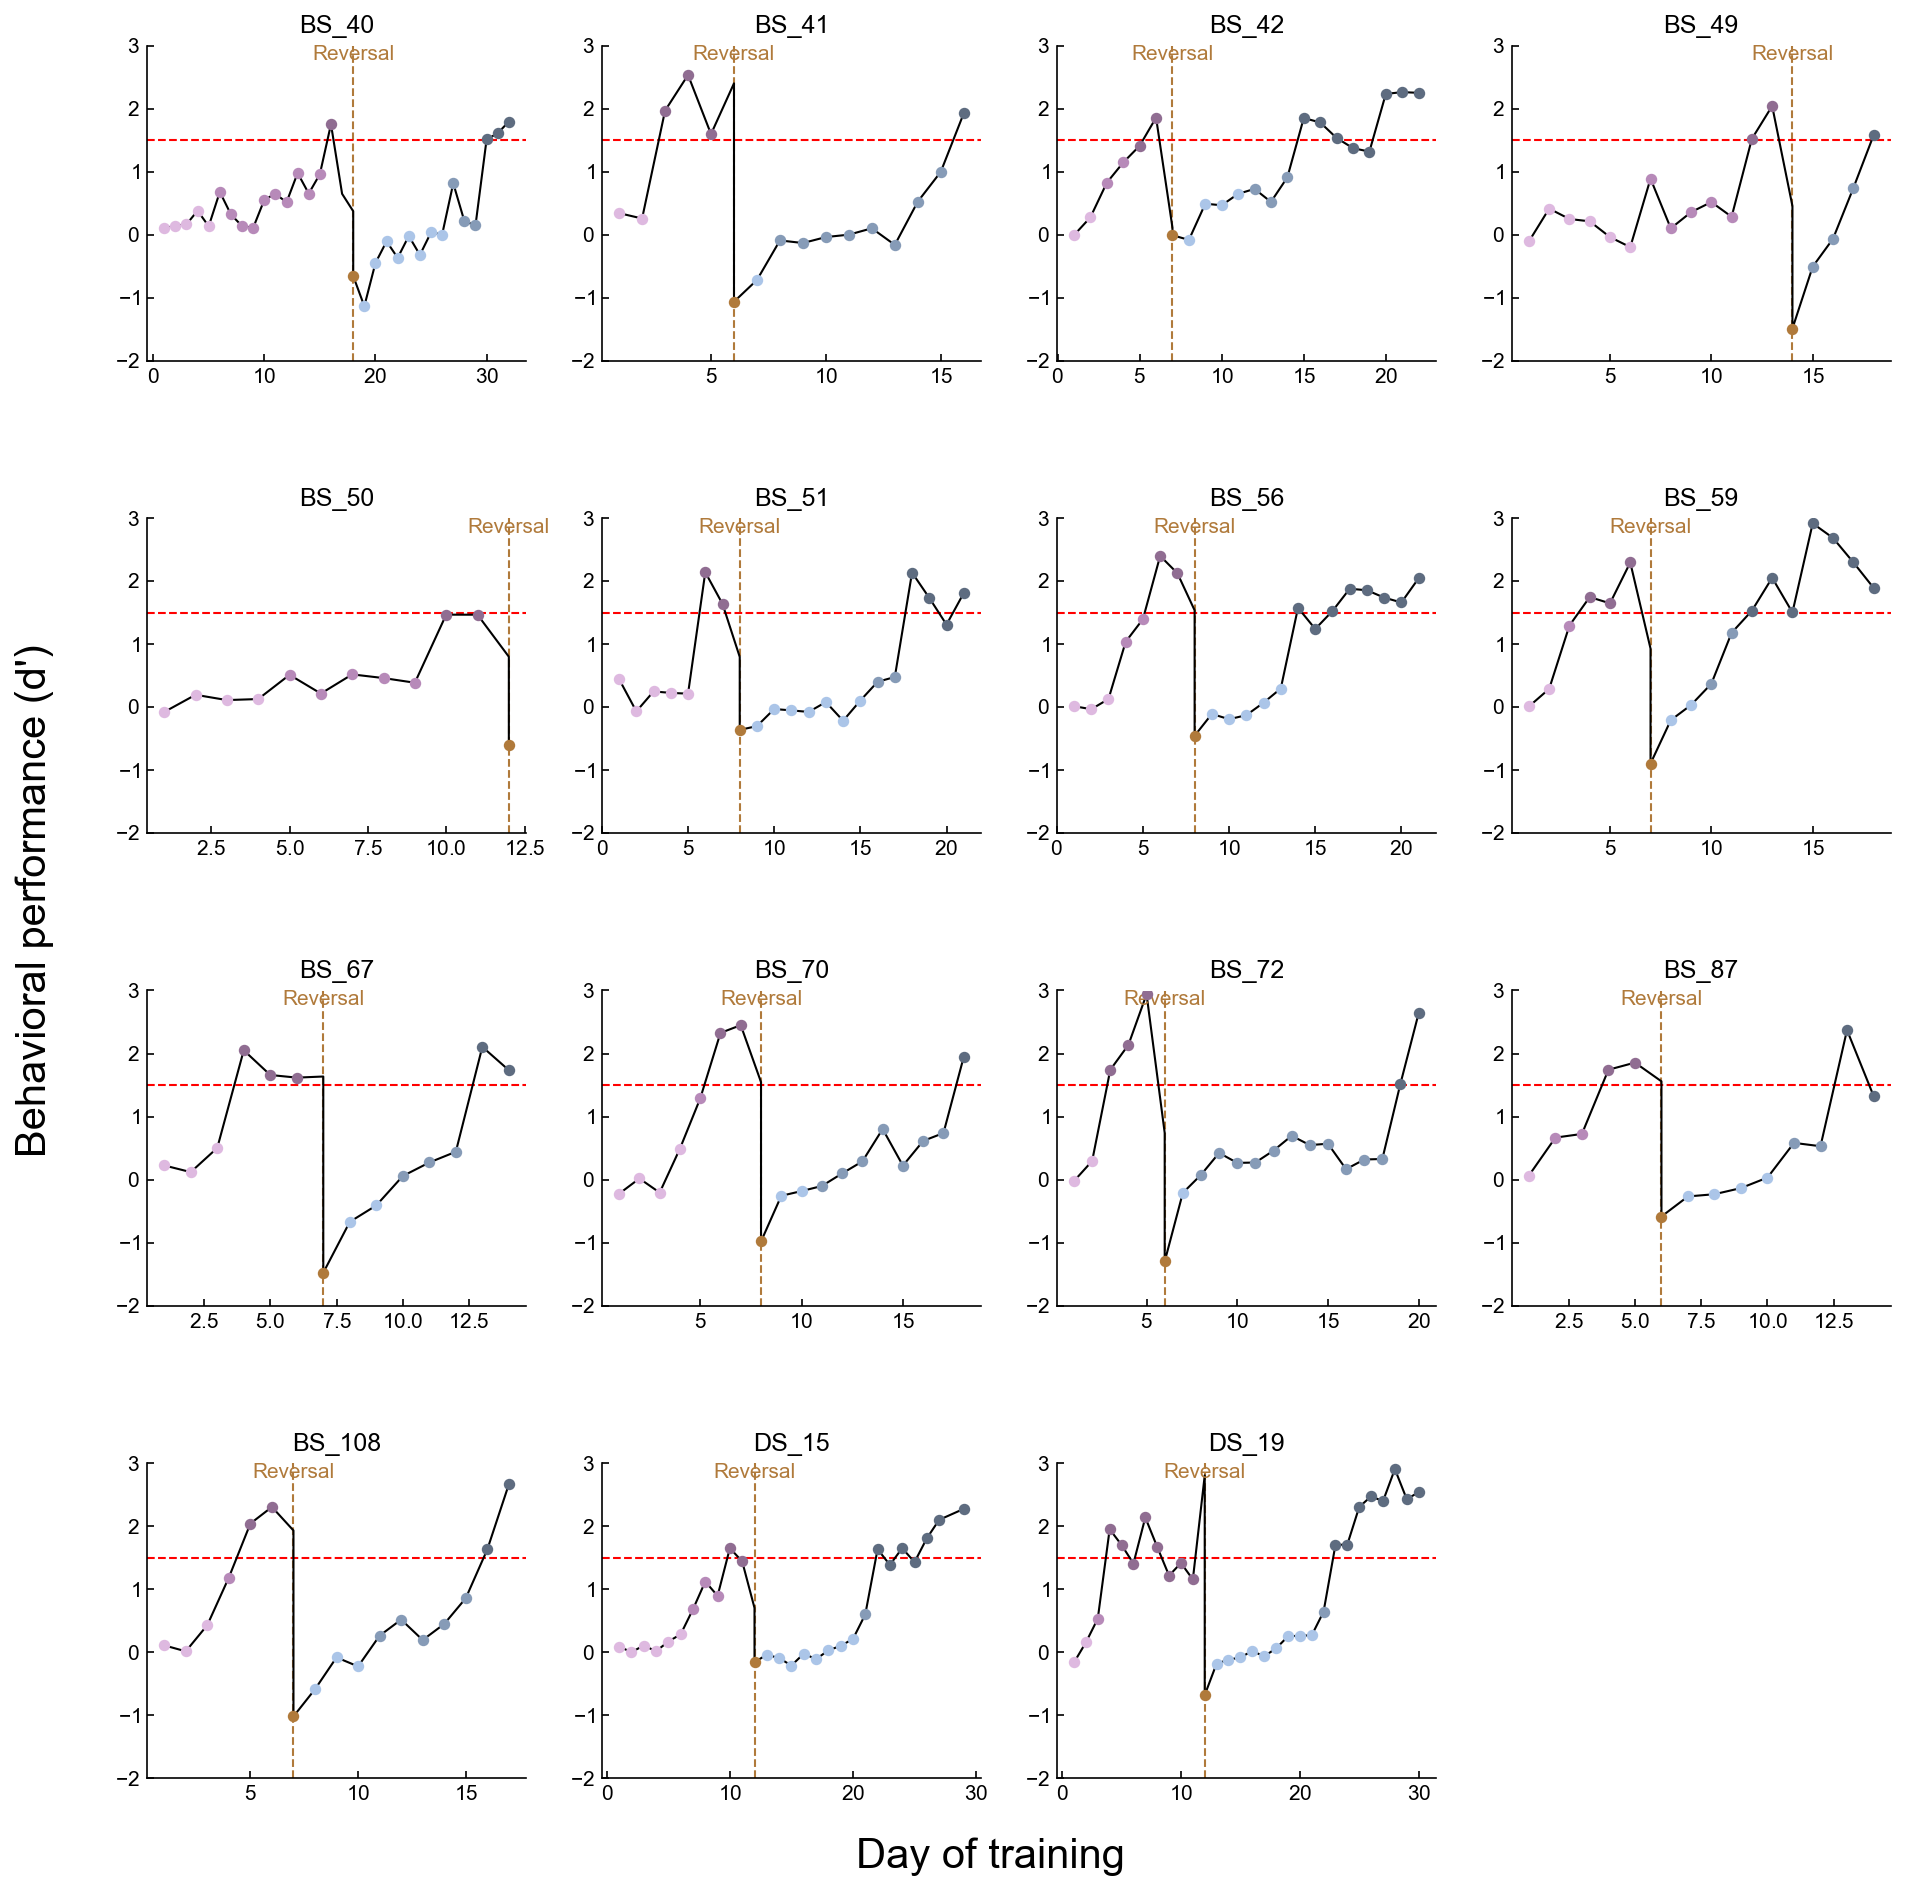

In [3]:
learning_phases,_,_ = ilep.calculateLearningPhasesV2(animals,animalBehaviors,plot=True)

In [4]:
act_directory

'D:\\Analysis_Cache_M2_300'

# Get data

In [5]:
EnumACSession = []
EnumACClust = []
EnumM2Session = []
EnumM2Clust = []

sessions = os.listdir(act_directory)

numAC = 0
numM2 = 0

for session in tqdm(sessions):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if sessionfile.meta.task in ['passive no beahvior']:
        continue
    if sessionfile.meta.task in ['tuning nonreversal','tuning switch','tuning reversal']:
        continue
    if sessionfile.meta.task in ['opto nonreversal','opto switch','opto reversal']:
        continue
    if sessionfile.meta.task in ['opto control nonreversal','opto control switch','opto control reversal']:
        continue
    
    if sessionfile.meta.animal not in animals:
        continue
    
    #attribute neurons based on the region
    if sessionfile.meta.region == 'AC':
        numAC += len(sessionfile.clusters.good)
        
        for clust in sessionfile.clusters.good:
            EnumACSession.append(session)
            EnumACClust.append(clust)
            
    elif sessionfile.meta.region == 'M2':
        numM2 += len(sessionfile.clusters.good)
        
        for clust in sessionfile.clusters.good:
            EnumM2Session.append(session)
            EnumM2Clust.append(clust)    
    else:
        pass

        
print('AC       : ' + str(numAC))
print('M2       : ' + str(numM2))

100%|██████████| 554/554 [00:07<00:00, 77.20it/s] 

AC       : 1831
M2       : 1624


In [6]:
EILM2phases = np.full_like(EnumM2Session,np.nan)
error_animals = []

for idx,session in enumerate(tqdm(EnumM2Session)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        animal = sessionfile.meta.animal
        day = sessionfile.meta.day_of_training
        
        if sessionfile.meta.task in ['switch']:
            EILM2phases[idx] = 'switch'

        elif sessionfile.meta.task in ['nonreversal'] and day in learning_phases[animal].pre_early_days:
            EILM2phases[idx] = 'pre early'
        elif sessionfile.meta.task in ['nonreversal']  and day in learning_phases[animal].pre_late_days:
            EILM2phases[idx] = 'pre late'
        elif sessionfile.meta.task in ['nonreversal'] and day in learning_phases[animal].pre_expert_days:
            EILM2phases[idx] = 'pre expert'

        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_early_days:
            EILM2phases[idx] = 'post early'
        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_late_days:
            EILM2phases[idx] = 'post late'
        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_expert_days:
            EILM2phases[idx] = 'post expert'
    except Exception as e:
        #print(ilep.generateDateString(sessionfile))
        error_animals.append(sessionfile.meta.animal)
        pass
                             
error_animals = np.unique(error_animals)
print('errors for: '+str(error_animals))

100%|██████████| 1624/1624 [00:31<00:00, 51.36it/s] 

errors for: []


In [7]:
EILACphases = np.full_like(EnumACSession,np.nan)
error_animals = []

for idx,session in enumerate(tqdm(EnumACSession)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        animal = sessionfile.meta.animal
        day = sessionfile.meta.day_of_training
        
        if sessionfile.meta.task in ['switch']:
            EILACphases[idx] = 'switch'

        elif sessionfile.meta.task in ['nonreversal'] and day in learning_phases[animal].pre_early_days:
            EILACphases[idx] = 'pre early'
        elif sessionfile.meta.task in ['nonreversal']  and day in learning_phases[animal].pre_late_days:
            EILACphases[idx] = 'pre late'
        elif sessionfile.meta.task in ['nonreversal'] and day in learning_phases[animal].pre_expert_days:
            EILACphases[idx] = 'pre expert'

        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_early_days:
            EILACphases[idx] = 'post early'
        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_late_days:
            EILACphases[idx] = 'post late'
        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_expert_days:
            EILACphases[idx] = 'post expert'
    except Exception as e:
        #print(ilep.generateDateString(sessionfile))
        error_animals.append(sessionfile.meta.animal)
        pass
                             
error_animals = np.unique(error_animals)
print('errors for: '+str(error_animals))

100%|██████████| 1831/1831 [00:35<00:00, 52.05it/s] 

errors for: []


In [8]:
learning_phases['BS_41'].post_expert_days

array([16])

In [9]:
sessionfile = ilep.loadSessionCached(act_directory,'BS_41_12_M2.pickle') #D18

In [10]:
np.unique(EnumACSession)

array(['BS_108_1_AC.pickle', 'BS_108_2_AC.pickle', 'BS_108_3_AC.pickle',
       'BS_108_4_AC.pickle', 'BS_108_6_AC.pickle', 'BS_40_10_AC.pickle',
       'BS_40_12_AC.pickle', 'BS_40_14_AC.pickle', 'BS_40_15_AC.pickle',
       'BS_40_16_AC.pickle', 'BS_40_18_AC.pickle', 'BS_40_19_AC.pickle',
       'BS_40_21_AC.pickle', 'BS_40_22_AC.pickle', 'BS_40_2_AC.pickle',
       'BS_40_3_AC.pickle', 'BS_40_4_AC.pickle', 'BS_40_5_AC.pickle',
       'BS_40_6_AC.pickle', 'BS_40_7_AC.pickle', 'BS_40_8_AC.pickle',
       'BS_41_11_AC.pickle', 'BS_41_1_AC.pickle', 'BS_41_2_AC.pickle',
       'BS_41_4_AC.pickle', 'BS_41_5_AC.pickle', 'BS_41_6_AC.pickle',
       'BS_41_7_AC.pickle', 'BS_41_8_AC.pickle', 'BS_41_9_AC.pickle',
       'BS_42_10_AC.pickle', 'BS_42_11_AC.pickle', 'BS_42_1_AC.pickle',
       'BS_42_2_AC.pickle', 'BS_42_3_AC.pickle', 'BS_42_4_AC.pickle',
       'BS_42_5_AC.pickle', 'BS_42_6_AC.pickle', 'BS_42_7_AC.pickle',
       'BS_42_8_AC.pickle', 'BS_42_9_AC.pickle', 'BS_49_10_AC.pickle',
  

In [11]:
np.unique(EnumM2Session)

array(['BS_108_1_M2.pickle', 'BS_108_2_M2.pickle', 'BS_108_3_M2.pickle',
       'BS_108_4_M2.pickle', 'BS_108_5_M2.pickle', 'BS_108_6_M2.pickle',
       'BS_108_7_M2.pickle', 'BS_40_10_M2.pickle', 'BS_40_11_M2.pickle',
       'BS_40_13_M2.pickle', 'BS_40_14_M2.pickle', 'BS_40_15_M2.pickle',
       'BS_40_16_M2.pickle', 'BS_40_2_M2.pickle', 'BS_40_3_M2.pickle',
       'BS_40_5_M2.pickle', 'BS_40_6_M2.pickle', 'BS_40_7_M2.pickle',
       'BS_41_11_M2.pickle', 'BS_41_12_M2.pickle', 'BS_41_1_M2.pickle',
       'BS_41_2_M2.pickle', 'BS_41_4_M2.pickle', 'BS_41_5_M2.pickle',
       'BS_41_6_M2.pickle', 'BS_41_7_M2.pickle', 'BS_41_9_M2.pickle',
       'BS_42_10_M2.pickle', 'BS_42_11_M2.pickle', 'BS_42_1_M2.pickle',
       'BS_42_2_M2.pickle', 'BS_42_3_M2.pickle', 'BS_42_4_M2.pickle',
       'BS_42_5_M2.pickle', 'BS_42_6_M2.pickle', 'BS_42_7_M2.pickle',
       'BS_42_8_M2.pickle', 'BS_42_9_M2.pickle', 'BS_49_13_M2.pickle',
       'BS_49_14_M2.pickle', 'BS_49_15_M2.pickle', 'BS_49_1_M2.pickle',


In [12]:
act_directory

'D:\\Analysis_Cache_M2_300'

# Spontaneous (window: -150 to 0ms)

## AC

In [13]:
FRb_preearly_AC = []
FRb_prelate_AC = []
FRb_preexpert_AC = []
FRb_postearly_AC = []
FRb_postlate_AC = []
FRb_postexpert_AC = []

FRe_preearly_AC = []
FRe_prelate_AC = []
FRe_preexpert_AC = []
FRe_postearly_AC = []
FRe_postlate_AC = []
FRe_postexpert_AC = []

FRet_preearly_AC = []
FRet_prelate_AC = []
FRet_preexpert_AC = []
FRet_postearly_AC = []
FRet_postlate_AC = []
FRet_postexpert_AC = []

FRent_preearly_AC = []
FRent_prelate_AC = []
FRent_preexpert_AC = []
FRent_postearly_AC = []
FRent_postlate_AC = []
FRent_postexpert_AC = []

preearly_animals_AC = []
prelate_animals_AC = []
preexpert_animals_AC = []
postearly_animals_AC = []
postlate_animals_AC = []
postexpert_animals_AC = []

cellstouseFR = 'all cells'
#cellstouseFR = 'task encoders'

for idx,(session,clust) in tqdm(enumerate(zip(EnumACSession,EnumACClust))):
    sessionfile = ilep.loadSessionCached(act_directory,session)

    #Currently not active as tuning curve animals have not been decoded
#     if cellstouseFR == 'task encoders':
#         if not np.isfinite(accuracies[idx]) or pvals[idx] > 0.05 or accuracies[idx] < task_encoder_threshold:
#             continue
        
#     if sessionfile.responsiveness[clust]['all_trials'].FR < sessionfile.responsiveness[clust]['all_trials'].FRbaseline:
#         #print('excluded')
#         #continue
#         pass
    
    if EILACphases[idx] not in ['pre expert','post expert'] and sessionfile.meta.animal in ['DS_15','DS_19']:
        continue
    
    try:
        FRmod_b = sessionfile.responsiveness[clust]['all_trials'].FRbaseline
        FRmod_e = sessionfile.responsiveness[clust]['all_trials'].FR
        FRmod_et = sessionfile.responsiveness[clust]['target'].FR
        FRmod_ent = sessionfile.responsiveness[clust]['nontarget'].FR
    except Exception as e:
        FRmod_b = np.nan
        FRmod_e = np.nan
        FRmod_et = np.nan
        FRmod_ent = np.nan
        print(e)
        
    if EILACphases[idx] == 'pre early':
        FRb_preearly_AC.append(FRmod_b)
        FRe_preearly_AC.append(FRmod_e)
        FRet_preearly_AC.append(FRmod_et)
        FRent_preearly_AC.append(FRmod_ent)
        preearly_animals_AC.append(sessionfile.meta.animal)                 
    elif EILACphases[idx] == 'pre late':
        FRb_prelate_AC.append(FRmod_b)
        FRe_prelate_AC.append(FRmod_e)
        FRet_prelate_AC.append(FRmod_et)
        FRent_prelate_AC.append(FRmod_ent)
        prelate_animals_AC.append(sessionfile.meta.animal)                  
    elif EILACphases[idx] == 'pre expert':
        FRb_preexpert_AC.append(FRmod_b)
        FRe_preexpert_AC.append(FRmod_e)
        FRet_preexpert_AC.append(FRmod_et)
        FRent_preexpert_AC.append(FRmod_ent)
        preexpert_animals_AC.append(sessionfile.meta.animal)                  
    elif EILACphases[idx] == 'post early':
        FRb_postearly_AC.append(FRmod_b)
        FRe_postearly_AC.append(FRmod_e)
        FRet_postearly_AC.append(FRmod_et)
        FRent_postearly_AC.append(FRmod_ent)
        postearly_animals_AC.append(sessionfile.meta.animal)                 
    elif EILACphases[idx] == 'post late':
        FRb_postlate_AC.append(FRmod_b)
        FRe_postlate_AC.append(FRmod_e)
        FRet_postlate_AC.append(FRmod_et)
        FRent_postlate_AC.append(FRmod_ent)
        postlate_animals_AC.append(sessionfile.meta.animal)                     
    elif EILACphases[idx] == 'post expert':
        FRb_postexpert_AC.append(FRmod_b)
        FRe_postexpert_AC.append(FRmod_e)
        FRet_postexpert_AC.append(FRmod_et)
        FRent_postexpert_AC.append(FRmod_ent)
        postexpert_animals_AC.append(sessionfile.meta.animal)


1831it [00:35, 52.28it/s] 


In [14]:
FRb_preearly_AC = np.array(FRb_preearly_AC)
FRb_prelate_AC = np.array(FRb_prelate_AC)
FRb_preexpert_AC = np.array(FRb_preexpert_AC)
FRb_postearly_AC = np.array(FRb_postearly_AC)
FRb_postlate_AC = np.array(FRb_postlate_AC)
FRb_postexpert_AC = np.array(FRb_postexpert_AC)

FRe_preearly_AC = np.array(FRe_preearly_AC)
FRe_prelate_AC = np.array(FRe_prelate_AC)
FRe_preexpert_AC = np.array(FRe_preexpert_AC)
FRe_postearly_AC = np.array(FRe_postearly_AC)
FRe_postlate_AC = np.array(FRe_postlate_AC)
FRe_postexpert_AC = np.array(FRe_postexpert_AC)

FRet_preearly_AC = np.array(FRet_preearly_AC)
FRet_prelate_AC = np.array(FRet_prelate_AC)
FRet_preexpert_AC = np.array(FRet_preexpert_AC)
FRet_postearly_AC = np.array(FRet_postearly_AC)
FRet_postlate_AC = np.array(FRet_postlate_AC)
FRet_postexpert_AC = np.array(FRet_postexpert_AC)

FRent_preearly_AC = np.array(FRent_preearly_AC)
FRent_prelate_AC = np.array(FRent_prelate_AC)
FRent_preexpert_AC = np.array(FRent_preexpert_AC)
FRent_postearly_AC = np.array(FRent_postearly_AC)
FRent_postlate_AC = np.array(FRent_postlate_AC)
FRent_postexpert_AC = np.array(FRent_postexpert_AC)

In [15]:
#number of animals in each learning phase

preearly_animals_AC = np.unique(preearly_animals_AC)
prelate_animals_AC = np.unique(prelate_animals_AC)
preexpert_animals_AC = np.unique(preexpert_animals_AC)
postearly_animals_AC = np.unique(postearly_animals_AC)
postlate_animals_AC = np.unique(postlate_animals_AC)
postexpert_animals_AC = np.unique(postexpert_animals_AC)

preearly_animals_num_AC = len(preearly_animals_AC)
prelate_animals_num_AC = len(prelate_animals_AC)
preexpert_animals_num_AC = len(preexpert_animals_AC)
postearly_animals_num_AC = len(postearly_animals_AC)
postlate_animals_num_AC = len(postlate_animals_AC)
postexpert_animals_num_AC = len(postexpert_animals_AC)

In [16]:
stdfont = 14
stdyfrac = 0.06

meta NOT subset; don't know how to subset; dropped


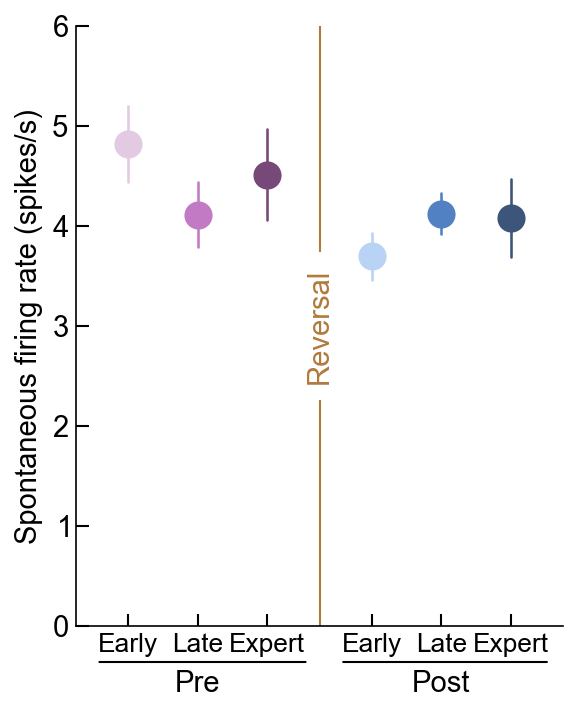

In [17]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.25
#switch_offset = 0
################################################################################################################

#Plot figure

data = [FRb_preearly_AC,FRb_prelate_AC,FRb_preexpert_AC,FRb_postearly_AC,FRb_postlate_AC,FRb_postexpert_AC]
PHASE_COLORS = ['#E2CAE3','#C27AC5','#764979','#B9D3F7','#5181C2','#3C557A']

numCon = len(data)
X = [np.ones(len(l))*idx for idx,l in enumerate(data)]

X,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.25)

numunits = [len(d) for d in data]
cumsumunits = np.cumsum(numunits)
unitsperphase= np.concatenate([[0],cumsumunits])


#Plot summary
for idx,column in enumerate(data):
    column = ilep.rmnan(column)
    
    eye_color=PHASE_COLORS[idx]
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    border_color=colorsys.hls_to_rgb(h,l*0.5,s)
    border_color = eye_color

    summary_size=150
    summary_width=1.25
    
    # Q1, median, Q3 = (np.nanpercentile(column, q) for q in [25, 50, 75])
    median = np.mean(column)
    Q1 = median - sem(column)
    Q3 = median + sem(column)
    
    if idx<3:
        ax.scatter([idx-switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
        ax.plot([idx-switch_offset, idx-switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    else:
        ax.scatter([idx+switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
        ax.plot([idx+switch_offset, idx+switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
################################################################################################################

labels = ['Early','Late','Expert','Early','Late','Expert']

ax.set_ylim([0,6])
ylab = ax.set_ylabel('Spontaneous firing rate (spikes/s)')

ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.04, -stdyfrac), xycoords='axes fraction', xytext=(0.48, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.54, -stdyfrac), xycoords='axes fraction', xytext=(0.975, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

### Log
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

### Linear
Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Multi-region\\spon_evok\\AC Spontaneous firing rate.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [18]:
FRbData_AC = SimpleNamespace()
FRbData_AC.preearly = FRb_preearly_AC
FRbData_AC.prelate = FRb_prelate_AC
FRbData_AC.preexpert = FRb_preexpert_AC
FRbData_AC.postearly = FRb_postearly_AC
FRbData_AC.postlate = FRb_postlate_AC
FRbData_AC.postexpert = FRb_postexpert_AC
ilep.nonparametricIndependentStatsCompareToPrevious(FRbData_AC)

            Source            SS      DF         MS         F     p-unc  \
0            phase     61.484076     3.0  20.494692  1.040046  0.373736   
1          context      1.931142     1.0   1.931142  0.098000  0.754279   
2  phase * context     79.352076     3.0  26.450692  1.342295  0.258928   
3         Residual  36376.477804  1846.0  19.705568       NaN       NaN   

        np2  
0  0.001687  
1  0.000053  
2  0.002177  
3       NaN  

          phase         A             B     p-unc    p-corr    hedges
7   post-expert  baseline  experimental  0.024530  0.098119  0.008887
8     post-late  baseline  experimental  0.083801  0.140663 -0.107792
9    pre-expert  baseline  experimental  0.579183  0.579183 -0.089627
10     pre-late  baseline  experimental  0.105497  0.140663  0.155603
key preearly has 148 non-nan elements
key prelate has 187 non-nan elements
key preexpert has 97 non-nan elements
key postearly has 306 non-nan elements
key postlate has 342 non-nan elements
key postexper

,Contrast,phase,A,B,Paired,Parametric,U-val,alternative,p-unc,p-corr,p-adjust,hedges
0,phase,-,post-expert,post-late,False,False,188273.0,two-sided,0.759707,0.759707,fdr_bh,0.041469
1,phase,-,post-expert,pre-expert,False,False,81220.5,two-sided,0.539984,0.759707,fdr_bh,-0.030154
2,phase,-,post-expert,pre-late,False,False,92550.0,two-sided,0.137772,0.562448,fdr_bh,-0.067125
3,phase,-,post-late,pre-expert,False,False,90324.0,two-sided,0.654750,0.759707,fdr_bh,-0.079228
4,phase,-,post-late,pre-late,False,False,102978.5,two-sided,0.187483,0.562448,fdr_bh,-0.120544
5,phase,-,pre-expert,pre-late,False,False,46098.5,two-sided,0.507024,0.759707,fdr_bh,-0.039065
6,context,-,baseline,experimental,False,False,435563.5,two-sided,0.516333,NaN,NaN,-0.013108
7,phase * context,post-expert,baseline,experimental,False,False,46452.0,two-sided,0.024530,0.098119,fdr_bh,0.008887
8,phase * context,post-late,baseline,experimental,False,False,48212.0,two-sided,0.083801,0.140663,fdr_bh,-0.107792
9,phase * context,pre-expert,baseline,experimental,False,False,8705.0,two-sided,0.579183,0.579183,fdr_bh,-0.089627


## M2

In [19]:
FRb_preearly = []
FRb_prelate = []
FRb_preexpert = []
FRb_postearly = []
FRb_postlate = []
FRb_postexpert = []

FRe_preearly = []
FRe_prelate = []
FRe_preexpert = []
FRe_postearly = []
FRe_postlate = []
FRe_postexpert = []

FRet_preearly = []
FRet_prelate = []
FRet_preexpert = []
FRet_postearly = []
FRet_postlate = []
FRet_postexpert = []

FRent_preearly = []
FRent_prelate = []
FRent_preexpert = []
FRent_postearly = []
FRent_postlate = []
FRent_postexpert = []

preearly_animals = []
prelate_animals = []
preexpert_animals = []
postearly_animals = []
postlate_animals = []
postexpert_animals = []

cellstouseFR = 'all cells'
#cellstouseFR = 'task encoders'

for idx,(session,clust) in tqdm(enumerate(zip(EnumM2Session,EnumM2Clust))):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    #Currently not active as tuning curve animals have not been decoded
#     if cellstouseFR == 'task encoders':
#         if not np.isfinite(accuracies[idx]) or pvals[idx] > 0.05 or accuracies[idx] < task_encoder_threshold:
#             continue
        
#     if sessionfile.responsiveness[clust]['all_trials'].FR < sessionfile.responsiveness[clust]['all_trials'].FRbaseline:
#         #print('excluded')
#         #continue
#         pass
    
    if EILM2phases[idx] not in ['pre expert','post expert'] and sessionfile.meta.animal in ['DS_15','DS_19']:
        continue
    
    try:
        FRmod_b = sessionfile.responsiveness[clust]['all_trials'].FRbaseline
        FRmod_e = sessionfile.responsiveness[clust]['all_trials'].FR
        FRmod_et = sessionfile.responsiveness[clust]['target'].FR
        FRmod_ent = sessionfile.responsiveness[clust]['nontarget'].FR
    except Exception as e:
        FRmod_b = np.nan
        FRmod_e = np.nan
        FRmod_et = np.nan
        FRmod_ent = np.nan
        print(e)
        
    if EILM2phases[idx] == 'pre early':
        FRb_preearly.append(FRmod_b)
        FRe_preearly.append(FRmod_e)
        FRet_preearly.append(FRmod_et)
        FRent_preearly.append(FRmod_ent)
        preearly_animals.append(sessionfile.meta.animal)                 
    elif EILM2phases[idx] == 'pre late':
        FRb_prelate.append(FRmod_b)
        FRe_prelate.append(FRmod_e)
        FRet_prelate.append(FRmod_et)
        FRent_prelate.append(FRmod_ent)
        prelate_animals.append(sessionfile.meta.animal)                  
    elif EILM2phases[idx] == 'pre expert':
        FRb_preexpert.append(FRmod_b)
        FRe_preexpert.append(FRmod_e)
        FRet_preexpert.append(FRmod_et)
        FRent_preexpert.append(FRmod_ent)
        preexpert_animals.append(sessionfile.meta.animal)                  
    elif EILM2phases[idx] == 'post early':
        FRb_postearly.append(FRmod_b)
        FRe_postearly.append(FRmod_e)
        FRet_postearly.append(FRmod_et)
        FRent_postearly.append(FRmod_ent)
        postearly_animals.append(sessionfile.meta.animal)                 
    elif EILM2phases[idx] == 'post late':
        FRb_postlate.append(FRmod_b)
        FRe_postlate.append(FRmod_e)
        FRet_postlate.append(FRmod_et)
        FRent_postlate.append(FRmod_ent)
        postlate_animals.append(sessionfile.meta.animal)                     
    elif EILM2phases[idx] == 'post expert':
        FRb_postexpert.append(FRmod_b)
        FRe_postexpert.append(FRmod_e)
        FRet_postexpert.append(FRmod_et)
        FRent_postexpert.append(FRmod_ent)
        postexpert_animals.append(sessionfile.meta.animal)


1624it [00:31, 51.44it/s] 


In [20]:
FRb_preearly = np.array(FRb_preearly)
FRb_prelate = np.array(FRb_prelate)
FRb_preexpert = np.array(FRb_preexpert)
FRb_postearly = np.array(FRb_postearly)
FRb_postlate = np.array(FRb_postlate)
FRb_postexpert = np.array(FRb_postexpert)

FRe_preearly = np.array(FRe_preearly)
FRe_prelate = np.array(FRe_prelate)
FRe_preexpert = np.array(FRe_preexpert)
FRe_postearly = np.array(FRe_postearly)
FRe_postlate = np.array(FRe_postlate)
FRe_postexpert = np.array(FRe_postexpert)

FRet_preearly = np.array(FRet_preearly)
FRet_prelate = np.array(FRet_prelate)
FRet_preexpert = np.array(FRet_preexpert)
FRet_postearly = np.array(FRet_postearly)
FRet_postlate = np.array(FRet_postlate)
FRet_postexpert = np.array(FRet_postexpert)

FRent_preearly = np.array(FRent_preearly)
FRent_prelate = np.array(FRent_prelate)
FRent_preexpert = np.array(FRent_preexpert)
FRent_postearly = np.array(FRent_postearly)
FRent_postlate = np.array(FRent_postlate)
FRent_postexpert = np.array(FRent_postexpert)

In [21]:
#number of animals in each learning phase

preearly_animals = np.unique(preearly_animals)
prelate_animals = np.unique(prelate_animals)
preexpert_animals = np.unique(preexpert_animals)
postearly_animals = np.unique(postearly_animals)
postlate_animals = np.unique(postlate_animals)
postexpert_animals = np.unique(postexpert_animals)

preearly_animals_num = len(preearly_animals)
prelate_animals_num = len(prelate_animals)
preexpert_animals_num = len(preexpert_animals)
postearly_animals_num = len(postearly_animals)
postlate_animals_num = len(postlate_animals)
postexpert_animals_num = len(postexpert_animals)

In [22]:
preearly_animals

array(['BS_49', 'BS_50'], dtype='<U5')

In [23]:
prelate_animals

array(['BS_40', 'BS_49', 'BS_50', 'BS_70'], dtype='<U5')

In [24]:
preexpert_animals

array(['BS_108', 'BS_50', 'BS_70', 'BS_72', 'BS_87'], dtype='<U6')

In [25]:
postearly_animals

array(['BS_108', 'BS_40', 'BS_41', 'BS_42', 'BS_70', 'BS_72', 'BS_87'],
      dtype='<U6')

In [26]:
postlate_animals

array(['BS_108', 'BS_41', 'BS_42', 'BS_49', 'BS_67', 'BS_70', 'BS_72',
       'BS_87'], dtype='<U6')

In [27]:
postexpert_animals

array(['BS_42', 'BS_51', 'BS_56', 'BS_59', 'BS_67'], dtype='<U5')

In [28]:
stdfont = 14
stdyfrac = 0.06

meta NOT subset; don't know how to subset; dropped


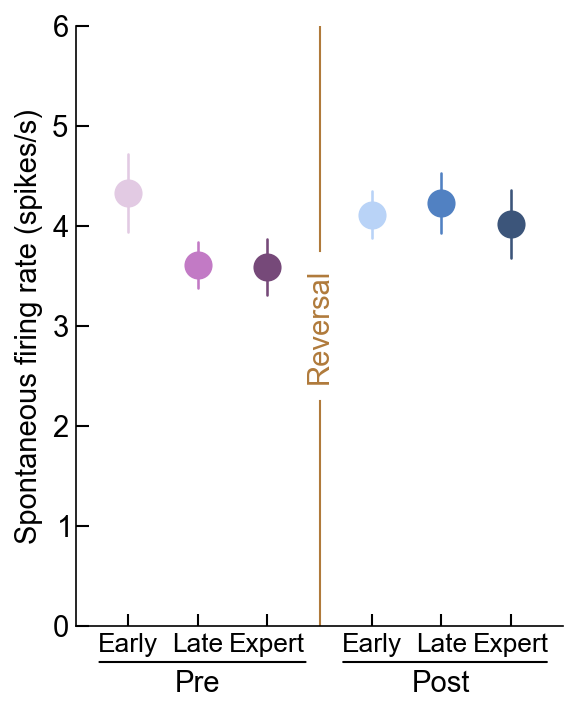

In [29]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.25
#switch_offset = 0
################################################################################################################

#Plot figure

data = [FRb_preearly,FRb_prelate,FRb_preexpert,FRb_postearly,FRb_postlate,FRb_postexpert]
PHASE_COLORS = ['#E2CAE3','#C27AC5','#764979','#B9D3F7','#5181C2','#3C557A']

numCon = len(data)
X = [np.ones(len(l))*idx for idx,l in enumerate(data)]

X,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.25)

numunits = [len(d) for d in data]
cumsumunits = np.cumsum(numunits)
unitsperphase= np.concatenate([[0],cumsumunits])


#Plot summary
for idx,column in enumerate(data):
    column = ilep.rmnan(column)
    
    eye_color=PHASE_COLORS[idx]
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    border_color=colorsys.hls_to_rgb(h,l*0.5,s)
    border_color = eye_color

    summary_size=150
    summary_width=1.25
    
    # Q1, median, Q3 = (np.nanpercentile(column, q) for q in [25, 50, 75])
    median = np.mean(column)
    Q1 = median - sem(column)
    Q3 = median + sem(column)
    
    if idx<3:
        ax.scatter([idx-switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
        ax.plot([idx-switch_offset, idx-switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    else:
        ax.scatter([idx+switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
        ax.plot([idx+switch_offset, idx+switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
################################################################################################################

labels = ['Early','Late','Expert','Early','Late','Expert']

ax.set_ylim([0,6])
ylab = ax.set_ylabel('Spontaneous firing rate (spikes/s)')

ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.04, -stdyfrac), xycoords='axes fraction', xytext=(0.48, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.54, -stdyfrac), xycoords='axes fraction', xytext=(0.975, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

### Log
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

### Linear
Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Multi-region\\spon_evok\\M2 Spontaneous firing rate.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [ ]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.25
#switch_offset = 0
################################################################################################################

#Plot figure

data = [FRe_preearly,FRe_prelate,FRe_preexpert,FRe_postearly,FRe_postlate,FRe_postexpert]
PHASE_COLORS = ['#E2CAE3','#C27AC5','#764979','#B9D3F7','#5181C2','#3C557A']

numCon = len(data)
X = [np.ones(len(l))*idx for idx,l in enumerate(data)]

X,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.25)

numunits = [len(d) for d in data]
cumsumunits = np.cumsum(numunits)
unitsperphase= np.concatenate([[0],cumsumunits])


#Plot summary
for idx,column in enumerate(data):
    column = ilep.rmnan(column)
    
    eye_color=PHASE_COLORS[idx]
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    border_color=colorsys.hls_to_rgb(h,l*0.5,s)
    border_color = eye_color

    summary_size=150
    summary_width=1.25
    
    # Q1, median, Q3 = (np.nanpercentile(column, q) for q in [25, 50, 75])
    median = np.mean(column)
    Q1 = median - sem(column)
    Q3 = median + sem(column)
    
    if idx<3:
        ax.scatter([idx-switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
        ax.plot([idx-switch_offset, idx-switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    else:
        ax.scatter([idx+switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
        ax.plot([idx+switch_offset, idx+switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')


################################################################################################################

labels = ['Early','Late','Expert','Early','Late','Expert']

ax.set_ylim([0,16])
ylab = ax.set_ylabel('Stimulus period firing rate (spikes/s)')

ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.04, -stdyfrac), xycoords='axes fraction', xytext=(0.48, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.54, -stdyfrac), xycoords='axes fraction', xytext=(0.975, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

### Log
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

### Linear
Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
#fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Multi-region\\spon_evok\\Evoked firing rate.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [31]:
FRbData = SimpleNamespace()
FRbData.preearly = FRb_preearly
FRbData.prelate = FRb_prelate
FRbData.preexpert = FRb_preexpert
FRbData.postearly = FRb_postearly
FRbData.postlate = FRb_postlate
FRbData.postexpert = FRb_postexpert
ilep.nonparametricIndependentStatsCompareToPrevious(FRbData)

            Source            SS      DF         MS         F     p-unc  \
0            phase     92.168039     3.0  30.722680  1.737385  0.157317   
1          context     13.346454     1.0  13.346454  0.754750  0.385093   
2  phase * context     42.599977     3.0  14.199992  0.803018  0.492127   
3         Residual  31688.453765  1792.0  17.683289       NaN       NaN   

        np2  
0  0.002900  
1  0.000421  
2  0.001343  
3       NaN  

          phase         A             B     p-unc    p-corr    hedges
7   post-expert  baseline  experimental  0.209731  0.419461  0.045668
8     post-late  baseline  experimental  0.932380  0.932380 -0.026766
9    pre-expert  baseline  experimental  0.511322  0.681763  0.005172
10     pre-late  baseline  experimental  0.055220  0.220880  0.174351
key preearly has 159 non-nan elements
key prelate has 239 non-nan elements
key preexpert has 183 non-nan elements
key postearly has 306 non-nan elements
key postlate has 247 non-nan elements
key postexpe

,Contrast,phase,A,B,Paired,Parametric,U-val,alternative,p-unc,p-corr,p-adjust,hedges
0,phase,-,post-expert,post-late,False,False,114801.5,two-sided,0.457611,0.606118,fdr_bh,-0.005429
1,phase,-,post-expert,pre-expert,False,False,95225.0,two-sided,0.151226,0.302452,fdr_bh,0.130456
2,phase,-,post-expert,pre-late,False,False,84704.5,two-sided,0.937544,0.937544,fdr_bh,0.055895
3,phase,-,post-late,pre-expert,False,False,126567.5,two-sided,0.023286,0.139714,fdr_bh,0.139407
4,phase,-,post-late,pre-late,False,False,112832.5,two-sided,0.505098,0.606118,fdr_bh,0.063170
5,phase,-,pre-expert,pre-late,False,False,79101.5,two-sided,0.150315,0.302452,fdr_bh,-0.076270
6,context,-,baseline,experimental,False,False,421993.0,two-sided,0.096556,NaN,NaN,0.042828
7,phase * context,post-expert,baseline,experimental,False,False,23810.0,two-sided,0.209731,0.419461,fdr_bh,0.045668
8,phase * context,post-late,baseline,experimental,False,False,37632.0,two-sided,0.932380,0.932380,fdr_bh,-0.026766
9,phase * context,pre-expert,baseline,experimental,False,False,22684.5,two-sided,0.511322,0.681763,fdr_bh,0.005172


## Sum

meta NOT subset; don't know how to subset; dropped


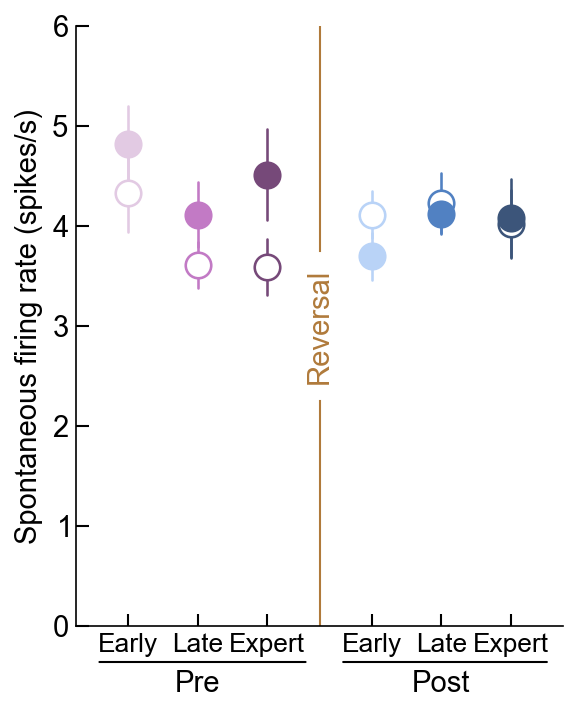

In [32]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.25
#switch_offset = 0
################################################################################################################

#Plot figure

data = [FRb_preearly,FRb_prelate,FRb_preexpert,FRb_postearly,FRb_postlate,FRb_postexpert]
PHASE_COLORS = ['#E2CAE3','#C27AC5','#764979','#B9D3F7','#5181C2','#3C557A']

numCon = len(data)
X = [np.ones(len(l))*idx for idx,l in enumerate(data)]

X,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.25)

numunits = [len(d) for d in data]
cumsumunits = np.cumsum(numunits)
unitsperphase= np.concatenate([[0],cumsumunits])


#Plot summary
for idx,column in enumerate(data):
    column = ilep.rmnan(column)
    
    eye_color=PHASE_COLORS[idx]
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    border_color=colorsys.hls_to_rgb(h,l*0.5,s)
    border_color = eye_color

    summary_size=150
    summary_width=1.25
    
    # Q1, median, Q3 = (np.nanpercentile(column, q) for q in [25, 50, 75])
    median = np.mean(column)
    Q1 = median - sem(column)
    Q3 = median + sem(column)
    
    if idx<3:
        ax.scatter([idx-switch_offset], [median], ec=eye_color,fc='white', s=summary_size,lw=summary_width, zorder=10,label='M2')
        ax.plot([idx-switch_offset, idx-switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    else:
        ax.scatter([idx+switch_offset], [median], ec=eye_color,fc='white', s=summary_size,lw=summary_width, zorder=10)
        ax.plot([idx+switch_offset, idx+switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
################################################################################################################

#Plot figure

data = [FRb_preearly_AC,FRb_prelate_AC,FRb_preexpert_AC,FRb_postearly_AC,FRb_postlate_AC,FRb_postexpert_AC]
PHASE_COLORS = ['#E2CAE3','#C27AC5','#764979','#B9D3F7','#5181C2','#3C557A']

numCon = len(data)
X = [np.ones(len(l))*idx for idx,l in enumerate(data)]

X,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.25)

numunits = [len(d) for d in data]
cumsumunits = np.cumsum(numunits)
unitsperphase= np.concatenate([[0],cumsumunits])


#Plot summary
for idx,column in enumerate(data):
    column = ilep.rmnan(column)
    
    eye_color=PHASE_COLORS[idx]
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    border_color=colorsys.hls_to_rgb(h,l*0.5,s)
    border_color = eye_color

    summary_size=150
    summary_width=1.25
    
    # Q1, median, Q3 = (np.nanpercentile(column, q) for q in [25, 50, 75])
    median = np.mean(column)
    Q1 = median - sem(column)
    Q3 = median + sem(column)
    
    if idx<3:
        ax.scatter([idx-switch_offset], [median], ec=eye_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10,label = 'AC')
        ax.plot([idx-switch_offset, idx-switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    else:
        ax.scatter([idx+switch_offset], [median], ec=eye_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
        ax.plot([idx+switch_offset, idx+switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    




################################################################################################################
labels = ['Early','Late','Expert','Early','Late','Expert']

ax.set_ylim([0,6])
ylab = ax.set_ylabel('Spontaneous firing rate (spikes/s)')

ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.04, -stdyfrac), xycoords='axes fraction', xytext=(0.48, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.54, -stdyfrac), xycoords='axes fraction', xytext=(0.975, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)
#ax.legend()

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

### Log
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

### Linear
Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Multi-region\\spon_evok\\Spontaneous firing rate.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [33]:
ilep.nonparametricIndependentStatsCompareToOther(FRbData_AC,FRbData)

            Source            SS      DF         MS         F     p-unc  \
0            phase    125.267610     5.0  25.053522  1.285005  0.267394   
1          context      8.861147     1.0   8.861147  0.454492  0.500269   
2  phase * context    118.316168     5.0  23.663234  1.213697  0.299951   
3         Residual  51218.155101  2627.0  19.496823       NaN       NaN   

        np2  
0  0.002440  
1  0.000173  
2  0.002305  
3       NaN  

          phase  A  B     p-unc    p-corr    hedges
16   post-early  A  B  0.134100  0.402299 -0.101437
17  post-expert  A  B  0.540403  0.648484  0.010875
18    post-late  A  B  0.913256  0.913256 -0.025820
19    pre-early  A  B  0.474747  0.648484  0.102336
20   pre-expert  A  B  0.119224  0.402299  0.228549
21     pre-late  A  B  0.467861  0.648484  0.126683
key preearly has 148 and 159 non-nan elements
key prelate has 187 and 239 non-nan elements
key preexpert has 97 and 183 non-nan elements
key postearly has 306 and 306 non-nan elements
key p

,Contrast,phase,A,B,Paired,Parametric,U-val,alternative,p-unc,p-corr,p-adjust,hedges
0,phase,-,post-early,post-expert,False,False,137235.0,two-sided,0.129856,0.243479,fdr_bh,-0.031531
1,phase,-,post-early,post-late,False,False,172804.0,two-sided,0.216304,0.324456,fdr_bh,-0.063370
2,phase,-,post-early,pre-early,False,False,84711.5,two-sided,0.015018,0.056318,fdr_bh,-0.151834
3,phase,-,post-early,pre-expert,False,False,87866.5,two-sided,0.540436,0.675545,fdr_bh,-0.000950
4,phase,-,post-early,pre-late,False,False,132259.5,two-sided,0.688762,0.737959,fdr_bh,0.018881
5,phase,-,post-expert,post-late,False,False,113448.5,two-sided,0.010909,0.056318,fdr_bh,-0.023915
6,phase,-,post-expert,pre-early,False,False,55787.0,two-sided,0.000816,0.012236,fdr_bh,-0.098448
7,phase,-,post-expert,pre-expert,False,False,58250.0,two-sided,0.636764,0.734728,fdr_bh,0.029217
8,phase,-,post-expert,pre-late,False,False,86768.0,two-sided,0.294757,0.401941,fdr_bh,0.047138
9,phase,-,post-late,pre-early,False,False,85441.0,two-sided,0.176428,0.294046,fdr_bh,-0.090442


# Evoked (window: 0 - 200 or 300ms)

In [34]:
# 200ms window for AC, 300ms for M2

## AC

In [35]:
Tuning_target_preearly_AC = []
Tuning_target_prelate_AC = []
Tuning_target_preexpert_AC = []
Tuning_target_postearly_AC = []
Tuning_target_postlate_AC = []
Tuning_target_postexpert_AC = []
Tuning_target_switch_AC = []

Tuning_nontarget_preearly_AC = []
Tuning_nontarget_prelate_AC = []
Tuning_nontarget_preexpert_AC = []
Tuning_nontarget_postearly_AC = []
Tuning_nontarget_postlate_AC = []
Tuning_nontarget_postexpert_AC = []
Tuning_nontarget_switch_AC = []

Tuning_index_preearly_AC = []
Tuning_index_prelate_AC = []
Tuning_index_preexpert_AC = []
Tuning_index_postearly_AC = []
Tuning_index_postlate_AC = []
Tuning_index_postexpert_AC = []
Tuning_index_switch_AC = []

cellstouseFR = 'all cells'
#cellstouseFR = 'task encoders'

for idx,(session,clust) in tqdm(enumerate(zip(EnumACSession,EnumACClust))):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    #Currently not active as tuning curve animals have not been decoded
    if cellstouseFR == 'task encoders':
        if not np.isfinite(accuracies[idx]) or pvals[idx] > 0.05 or accuracies[idx] < task_encoder_threshold:
            continue
        
#     if sessionfile.responsiveness[clust]['all_trials'].FR < sessionfile.responsiveness[clust]['all_trials'].FRbaseline:
#         #print('excluded')
#         #continue
#         pass
    
    if EILACphases[idx] not in ['pre expert','post expert'] and sessionfile.meta.animal in ['DS_15','DS_19']:
        continue
        
    try:
        FR_target = sessionfile.responsiveness[clust]['target'].FR
        FR_bl_target = sessionfile.responsiveness[clust]['target'].FRbaseline
        FR_nontarget = sessionfile.responsiveness[clust]['nontarget'].FR
        FR_bl_nontarget = sessionfile.responsiveness[clust]['nontarget'].FRbaseline
        Tuning_target = (FR_target - FR_bl_target)# / FR_bl_target
        Tuning_nontarget = (FR_nontarget - FR_bl_nontarget)# / FR_bl_nontarget
        Tuning_index = (FR_target - FR_nontarget)# / (FR_target+FR_nontarget)
    except Exception as e:
        Tuning_target = np.nan
        Tuning_nontarget = np.nan
        Tuning_index = np.nan
        print(e)
        
    if EILACphases[idx] == 'switch':
        Tuning_target_switch_AC.append(Tuning_target)
        Tuning_nontarget_switch_AC.append(Tuning_nontarget)
        Tuning_index_switch_AC.append(Tuning_index)

    if EILACphases[idx] == 'pre early':
        Tuning_target_preearly_AC.append(Tuning_target)
        Tuning_nontarget_preearly_AC.append(Tuning_nontarget)
        Tuning_index_preearly_AC.append(Tuning_index)

    elif EILACphases[idx] == 'pre late':
        Tuning_target_prelate_AC.append(Tuning_target)
        Tuning_nontarget_prelate_AC.append(Tuning_nontarget)
        Tuning_index_prelate_AC.append(Tuning_index)

    elif EILACphases[idx] == 'pre expert':
        Tuning_target_preexpert_AC.append(Tuning_target)
        Tuning_nontarget_preexpert_AC.append(Tuning_nontarget)
        Tuning_index_preexpert_AC.append(Tuning_index)

    elif EILACphases[idx] == 'post early':
        Tuning_target_postearly_AC.append(Tuning_target)
        Tuning_nontarget_postearly_AC.append(Tuning_nontarget)
        Tuning_index_postearly_AC.append(Tuning_index)

    elif EILACphases[idx] == 'post late':
        Tuning_target_postlate_AC.append(Tuning_target)
        Tuning_nontarget_postlate_AC.append(Tuning_nontarget)
        Tuning_index_postlate_AC.append(Tuning_index)

    elif EILACphases[idx] == 'post expert':
        Tuning_target_postexpert_AC.append(Tuning_target)
        Tuning_nontarget_postexpert_AC.append(Tuning_nontarget)
        Tuning_index_postexpert_AC.append(Tuning_index)

Tuning_target_preearly_AC = np.array(ilep.rmnan(Tuning_target_preearly_AC))
Tuning_target_prelate_AC = np.array(ilep.rmnan(Tuning_target_prelate_AC))
Tuning_target_preexpert_AC = np.array(ilep.rmnan(Tuning_target_preexpert_AC))
Tuning_target_postearly_AC = np.array(ilep.rmnan(Tuning_target_postearly_AC))
Tuning_target_postlate_AC = np.array(ilep.rmnan(Tuning_target_postlate_AC))
Tuning_target_postexpert_AC = np.array(ilep.rmnan(Tuning_target_postexpert_AC))

Tuning_nontarget_preearly_AC = np.array(ilep.rmnan(Tuning_nontarget_preearly_AC))
Tuning_nontarget_prelate_AC = np.array(ilep.rmnan(Tuning_nontarget_prelate_AC))
Tuning_nontarget_preexpert_AC = np.array(ilep.rmnan(Tuning_nontarget_preexpert_AC))
Tuning_nontarget_postearly_AC = np.array(ilep.rmnan(Tuning_nontarget_postearly_AC))
Tuning_nontarget_postlate_AC = np.array(ilep.rmnan(Tuning_nontarget_postlate_AC))
Tuning_nontarget_postexpert_AC = np.array(ilep.rmnan(Tuning_nontarget_postexpert_AC))

Tuning_index_preearly_AC = np.array(ilep.rmnan(Tuning_index_preearly_AC))
Tuning_index_prelate_AC = np.array(ilep.rmnan(Tuning_index_prelate_AC))
Tuning_index_preexpert_AC = np.array(ilep.rmnan(Tuning_index_preexpert_AC))
Tuning_index_postearly_AC = np.array(ilep.rmnan(Tuning_index_postearly_AC))
Tuning_index_postlate_AC = np.array(ilep.rmnan(Tuning_index_postlate_AC))
Tuning_index_postexpert_AC = np.array(ilep.rmnan(Tuning_index_postexpert_AC))

1831it [00:35, 51.24it/s] 


148
187
97
306
342
245
148
187
97
306
342
244


meta NOT subset; don't know how to subset; dropped


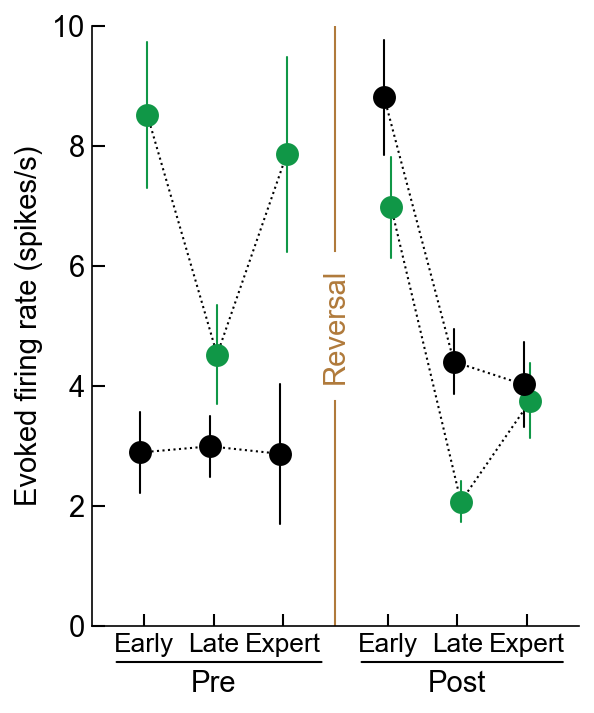

In [40]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.25
offset_distance = 0.05

################################################################################################################

data = [Tuning_target_preearly_AC,Tuning_target_prelate_AC,Tuning_target_preexpert_AC,Tuning_target_postearly_AC,Tuning_target_postlate_AC,Tuning_target_postexpert_AC]
data = [ilep.rmnan(d) for d in data]
#Plot summary
colmaxes = [np.nan]*6
for idx,(column,polarity) in enumerate(zip(data,[-1,-1,-1,1,1,1])):
    eye_color = TARGET_COLOR#PHASE_COLORS[idx]
    border_color=eye_color
    summary_size=100
    summary_width=1
    
    #Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    median = np.mean(column)
    Q1 = median - sem(column)
    Q3 = median + sem(column)
    colmaxes[idx] = Q3
    
    ax.scatter([idx+offset_distance+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+offset_distance+polarity*switch_offset, idx+offset_distance+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
medians = [np.mean(col) for col in data]
plt.plot(np.linspace(0,2,3)+offset_distance-switch_offset,medians[0:3],color='k',linestyle=':',lw=1)
plt.plot(np.linspace(3,5,3)+offset_distance+switch_offset,medians[3:6],color='k',linestyle=':',lw=1)
    
########################################################
data_two = [Tuning_nontarget_preearly_AC,Tuning_nontarget_prelate_AC,Tuning_nontarget_preexpert_AC,Tuning_nontarget_postearly_AC,Tuning_nontarget_postlate_AC,Tuning_nontarget_postexpert_AC]
data_two = [ilep.rmnan(d) for d in data_two]

#Plot summary
passive_colmaxes = [np.nan]*6
for idx,(column,polarity) in enumerate(zip(data_two,[-1,-1,-1,1,1,1])):
    border_color=NONTARGET_COLOR#PHASE_COLORS[idx]
    eye_color=border_color#'white'

    summary_size=100
    summary_width=1
    
    #Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    median = np.mean(column)
    Q1 = median - sem(column)
    Q3 = median + sem(column)
    passive_colmaxes[idx] = Q3
    
    ax.scatter([idx-offset_distance+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10,marker='o')
    ax.plot([idx-offset_distance+polarity*switch_offset, idx-offset_distance+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
medians = [np.mean(col) for col in data_two]
plt.plot(np.linspace(0,2,3)-offset_distance-switch_offset,medians[0:3],color='k',linestyle=':',lw=1)
plt.plot(np.linspace(3,5,3)-offset_distance+switch_offset,medians[3:6],color='k',linestyle=':',lw=1)

################################################################################################################

labels = ['Early','Late','Expert','Early','Late','Expert']
# labels2 = [1,2,3,4,5,6]

ax.set_ylim([0,10])
#ax.set_yticks([4,5,6,7,8,9,10,11])
#ax.set_yticklabels([4,5,6,7,8,9,10,11])
ylab = ax.set_ylabel('Evoked firing rate (spikes/s)')
              
ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)

# ax2 = ax.twiny()
# ax2.spines['top'].set_visible(True)
# ax2.get_xaxis().set_visible(True)
# ax2.set_xlim([-0.5-switch_offset,5.5+switch_offset])
# ax2.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
# ax2.set_xticklabels(labels2)
# xlab2 = ax2.set_xlabel('Passive exposure phase')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.0425, -stdyfrac), xycoords='axes fraction', xytext=(0.48, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.545, -stdyfrac), xycoords='axes fraction', xytext=(0.975, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)
# ax2.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass
# for item in ([ax2.title, ax2.xaxis.label, ax2.yaxis.label] +
#     ax2.get_xticklabels() + ax2.get_yticklabels()):
#     item.set_fontsize(stdfont)

ax.scatter([], [], ec=TARGET_COLOR,fc=TARGET_COLOR, s=summary_size,lw=summary_width,marker='o',label='Target')
ax.scatter([], [], ec=NONTARGET_COLOR,fc=NONTARGET_COLOR, s=summary_size,lw=summary_width,marker='o',label='Nontarget')
# lgd = ax.legend(frameon=False,loc=(0.8,0.8),fontsize=14)
    
### Log
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

### Linear
Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

# artists = [ylab,t1,t2,lgd]
artists = [ylab,t1,t2]

print(len(Tuning_target_preearly_AC))
print(len(Tuning_target_prelate_AC))
print(len(Tuning_target_preexpert_AC))
print(len(Tuning_target_postearly_AC))
print(len(Tuning_target_postlate_AC))
print(len(Tuning_target_postexpert_AC))
print(len(Tuning_nontarget_preearly_AC))
print(len(Tuning_nontarget_prelate_AC))
print(len(Tuning_nontarget_preexpert_AC))
print(len(Tuning_nontarget_postearly_AC))
print(len(Tuning_nontarget_postlate_AC))
print(len(Tuning_nontarget_postexpert_AC))

fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Multi-region\\spon_evok\\AC Evoked firing rate.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [39]:
148+187+97+306+342+245

1325

In [37]:
# data_target_AC = SimpleNamespace()
# data_target_AC.preearly = np.abs(Tuning_target_preearly_AC)
# data_target_AC.prelate = np.abs(Tuning_target_prelate_AC)
# data_target_AC.preexpert = np.abs(Tuning_target_preexpert_AC)
# data_target_AC.postearly = np.abs(Tuning_target_postearly_AC)
# data_target_AC.postlate = np.abs(Tuning_target_postlate_AC)
# data_target_AC.postexpert = np.abs(Tuning_target_postexpert_AC)

# data_nontarget_AC = SimpleNamespace()
# data_nontarget_AC.preearly = np.abs(Tuning_nontarget_preearly_AC)
# data_nontarget_AC.prelate = np.abs(Tuning_nontarget_prelate_AC)
# data_nontarget_AC.preexpert = np.abs(Tuning_nontarget_preexpert_AC)
# data_nontarget_AC.postearly = np.abs(Tuning_nontarget_postearly_AC)
# data_nontarget_AC.postlate = np.abs(Tuning_nontarget_postlate_AC)
# data_nontarget_AC.postexpert = np.abs(Tuning_nontarget_postexpert_AC)

data_target_AC = SimpleNamespace()
data_target_AC.preearly = Tuning_target_preearly_AC
data_target_AC.prelate = Tuning_target_prelate_AC
data_target_AC.preexpert = Tuning_target_preexpert_AC
data_target_AC.postearly = Tuning_target_postearly_AC
data_target_AC.postlate = Tuning_target_postlate_AC
data_target_AC.postexpert = Tuning_target_postexpert_AC

data_nontarget_AC = SimpleNamespace()
data_nontarget_AC.preearly = Tuning_nontarget_preearly_AC
data_nontarget_AC.prelate = Tuning_nontarget_prelate_AC
data_nontarget_AC.preexpert = Tuning_nontarget_preexpert_AC
data_nontarget_AC.postearly = Tuning_nontarget_postearly_AC
data_nontarget_AC.postlate = Tuning_nontarget_postlate_AC
data_nontarget_AC.postexpert = Tuning_nontarget_postexpert_AC

In [38]:
ilep.nonparametricIndependentStatsCompareToPrevious(data_target_AC)
pass
# 0.05 = *
# 0.01 = **
# 0.001 = ***
# 0.0001 = ****

            Source             SS      DF           MS          F  \
0            phase    3380.311657     3.0  1126.770552   9.445895   
1          context     992.283583     1.0   992.283583   8.318470   
2  phase * context    5326.325394     3.0  1775.441798  14.883808   
3         Residual  220203.425319  1846.0   119.286796        NaN   

          p-unc       np2  
0  3.410865e-06  0.015119  
1  3.969890e-03  0.004486  
2  1.414901e-09  0.023617  
3           NaN       NaN  

          phase         A             B         p-unc        p-corr    hedges
7   post-expert  baseline  experimental  1.263090e-02  1.684120e-02 -0.211322
8     post-late  baseline  experimental  1.256571e-07  5.026283e-07  0.441669
9    pre-expert  baseline  experimental  1.653783e-01  1.653783e-01 -0.255090
10     pre-late  baseline  experimental  2.640948e-04  5.281897e-04  0.307938
key preearly has 148 non-nan elements
key prelate has 187 non-nan elements
key preexpert has 97 non-nan elements
key postea

In [51]:
1.263090e-02

0.0126309

In [52]:
1.256571e-07< 0.0001

True

In [53]:
1.653783e-01

0.1653783

In [54]:
5.281897e-04

0.0005281897

In [39]:
ilep.nonparametricIndependentStatsCompareToPrevious(data_nontarget_AC)
pass
# 0.05 = *
# 0.01 = **
# 0.001 = ***
# 0.0001 = ****

            Source             SS      DF           MS          F  \
0            phase    4380.504562     3.0  1460.168187  12.075992   
1          context    1299.259985     1.0  1299.259985  10.745237   
2  phase * context    1856.467309     3.0   618.822436   5.117832   
3         Residual  223088.112535  1845.0   120.914966        NaN   

          p-unc       np2  
0  7.913433e-08  0.019258  
1  1.064909e-03  0.005790  
2  1.581809e-03  0.008253  
3           NaN       NaN  

          phase         A             B     p-unc    p-corr    hedges
7   post-expert  baseline  experimental  0.639270  0.639270  0.036405
8     post-late  baseline  experimental  0.000008  0.000031  0.323667
9    pre-expert  baseline  experimental  0.265722  0.354296  0.014287
10     pre-late  baseline  experimental  0.251947  0.354296 -0.013632
key preearly has 148 non-nan elements
key prelate has 187 non-nan elements
key preexpert has 97 non-nan elements
key postearly has 306 non-nan elements
key postlat

## M2

In [41]:
Tuning_target_preearly = []
Tuning_target_prelate = []
Tuning_target_preexpert = []
Tuning_target_postearly = []
Tuning_target_postlate = []
Tuning_target_postexpert = []
Tuning_target_switch = []

Tuning_nontarget_preearly = []
Tuning_nontarget_prelate = []
Tuning_nontarget_preexpert = []
Tuning_nontarget_postearly = []
Tuning_nontarget_postlate = []
Tuning_nontarget_postexpert = []
Tuning_nontarget_switch = []

Tuning_index_preearly = []
Tuning_index_prelate = []
Tuning_index_preexpert = []
Tuning_index_postearly = []
Tuning_index_postlate = []
Tuning_index_postexpert = []
Tuning_index_switch = []

preearly_animals = []
prelate_animals = []
preexpert_animals = []
postearly_animals = []
postlate_animals = []
postexpert_animals = []

cellstouseFR = 'all cells'
#cellstouseFR = 'task encoders'

for idx,(session,clust) in tqdm(enumerate(zip(EnumM2Session,EnumM2Clust))):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    #Currently not active as tuning curve animals have not been decoded
    if cellstouseFR == 'task encoders':
        if not np.isfinite(accuracies[idx]) or pvals[idx] > 0.05 or accuracies[idx] < task_encoder_threshold:
            continue
        
#     if sessionfile.responsiveness[clust]['all_trials'].FR < sessionfile.responsiveness[clust]['all_trials'].FRbaseline:
#         #print('excluded')
#         #continue
#         pass
    
    if EILM2phases[idx] not in ['pre expert','post expert'] and sessionfile.meta.animal in ['DS_15','DS_19']:
        continue
        
    try:
        FR_target = sessionfile.responsiveness[clust]['target'].FR
        FR_bl_target = sessionfile.responsiveness[clust]['target'].FRbaseline
        FR_nontarget = sessionfile.responsiveness[clust]['nontarget'].FR
        FR_bl_nontarget = sessionfile.responsiveness[clust]['nontarget'].FRbaseline
        Tuning_target = (FR_target - FR_bl_target)# / FR_bl_target
        Tuning_nontarget = (FR_nontarget - FR_bl_nontarget)# / FR_bl_nontarget
        Tuning_index = (FR_target - FR_nontarget)# / (FR_target+FR_nontarget)
    except Exception as e:
        Tuning_target = np.nan
        Tuning_nontarget = np.nan
        Tuning_index = np.nan
        print(e)
        
    if EILM2phases[idx] == 'switch':
        Tuning_target_switch.append(Tuning_target)
        Tuning_nontarget_switch.append(Tuning_nontarget)
        Tuning_index_switch.append(Tuning_index)
        

    if EILM2phases[idx] == 'pre early':
        Tuning_target_preearly.append(Tuning_target)
        Tuning_nontarget_preearly.append(Tuning_nontarget)
        Tuning_index_preearly.append(Tuning_index)
        preearly_animals.append(sessionfile.meta.animal)
        
    elif EILM2phases[idx] == 'pre late':
        Tuning_target_prelate.append(Tuning_target)
        Tuning_nontarget_prelate.append(Tuning_nontarget)
        Tuning_index_prelate.append(Tuning_index)
        prelate_animals.append(sessionfile.meta.animal)
        
    elif EILM2phases[idx] == 'pre expert':
        Tuning_target_preexpert.append(Tuning_target)
        Tuning_nontarget_preexpert.append(Tuning_nontarget)
        Tuning_index_preexpert.append(Tuning_index)
        preexpert_animals.append(sessionfile.meta.animal)
        
    elif EILM2phases[idx] == 'post early':
        Tuning_target_postearly.append(Tuning_target)
        Tuning_nontarget_postearly.append(Tuning_nontarget)
        Tuning_index_postearly.append(Tuning_index)
        postearly_animals.append(sessionfile.meta.animal)
        
    elif EILM2phases[idx] == 'post late':
        Tuning_target_postlate.append(Tuning_target)
        Tuning_nontarget_postlate.append(Tuning_nontarget)
        Tuning_index_postlate.append(Tuning_index)
        postlate_animals.append(sessionfile.meta.animal)
        
    elif EILM2phases[idx] == 'post expert':
        Tuning_target_postexpert.append(Tuning_target)
        Tuning_nontarget_postexpert.append(Tuning_nontarget)
        Tuning_index_postexpert.append(Tuning_index)
        postexpert_animals.append(sessionfile.meta.animal)

Tuning_target_preearly = np.array(ilep.rmnan(Tuning_target_preearly))
Tuning_target_prelate = np.array(ilep.rmnan(Tuning_target_prelate))
Tuning_target_preexpert = np.array(ilep.rmnan(Tuning_target_preexpert))
Tuning_target_postearly = np.array(ilep.rmnan(Tuning_target_postearly))
Tuning_target_postlate = np.array(ilep.rmnan(Tuning_target_postlate))
Tuning_target_postexpert = np.array(ilep.rmnan(Tuning_target_postexpert))

Tuning_nontarget_preearly = np.array(ilep.rmnan(Tuning_nontarget_preearly))
Tuning_nontarget_prelate = np.array(ilep.rmnan(Tuning_nontarget_prelate))
Tuning_nontarget_preexpert = np.array(ilep.rmnan(Tuning_nontarget_preexpert))
Tuning_nontarget_postearly = np.array(ilep.rmnan(Tuning_nontarget_postearly))
Tuning_nontarget_postlate = np.array(ilep.rmnan(Tuning_nontarget_postlate))
Tuning_nontarget_postexpert = np.array(ilep.rmnan(Tuning_nontarget_postexpert))

Tuning_index_preearly = np.array(ilep.rmnan(Tuning_index_preearly))
Tuning_index_prelate = np.array(ilep.rmnan(Tuning_index_prelate))
Tuning_index_preexpert = np.array(ilep.rmnan(Tuning_index_preexpert))
Tuning_index_postearly = np.array(ilep.rmnan(Tuning_index_postearly))
Tuning_index_postlate = np.array(ilep.rmnan(Tuning_index_postlate))
Tuning_index_postexpert = np.array(ilep.rmnan(Tuning_index_postexpert))

1624it [00:32, 50.10it/s] 


In [42]:
#number of animals in each learning phase

preearly_animals = np.unique(preearly_animals)
prelate_animals = np.unique(prelate_animals)
preexpert_animals = np.unique(preexpert_animals)
postearly_animals = np.unique(postearly_animals)
postlate_animals = np.unique(postlate_animals)
postexpert_animals = np.unique(postexpert_animals)

preearly_animals_num = len(preearly_animals)
prelate_animals_num = len(prelate_animals)
preexpert_animals_num = len(preexpert_animals)
postearly_animals_num = len(postearly_animals)
postlate_animals_num = len(postlate_animals)
postexpert_animals_num = len(postexpert_animals)

In [43]:
preearly_animals

array(['BS_49', 'BS_50'], dtype='<U5')

In [44]:
prelate_animals

array(['BS_40', 'BS_49', 'BS_50', 'BS_70'], dtype='<U5')

In [45]:
preexpert_animals

array(['BS_108', 'BS_50', 'BS_70', 'BS_72', 'BS_87'], dtype='<U6')

In [46]:
postearly_animals

array(['BS_108', 'BS_40', 'BS_41', 'BS_42', 'BS_70', 'BS_72', 'BS_87'],
      dtype='<U6')

In [47]:
postlate_animals

array(['BS_108', 'BS_41', 'BS_42', 'BS_49', 'BS_67', 'BS_70', 'BS_72',
       'BS_87'], dtype='<U6')

In [48]:
postexpert_animals

array(['BS_42', 'BS_51', 'BS_56', 'BS_59', 'BS_67'], dtype='<U5')

meta NOT subset; don't know how to subset; dropped


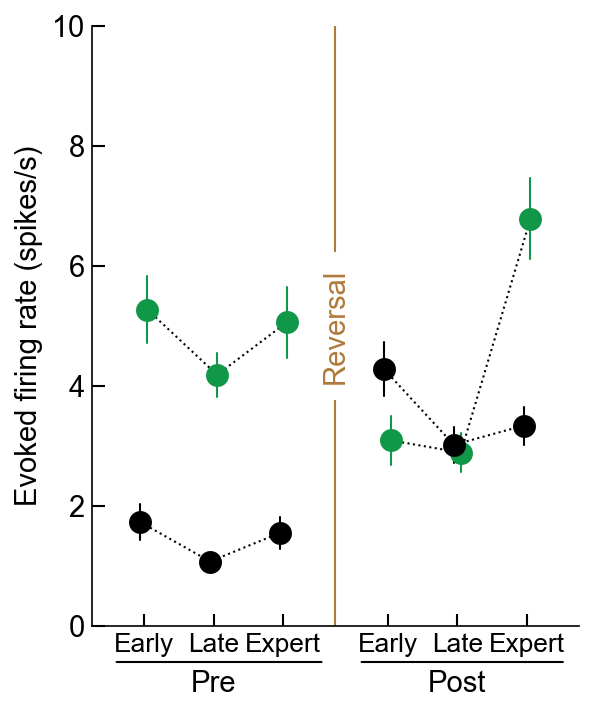

In [49]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.25
offset_distance = 0.05

################################################################################################################

data = [Tuning_target_preearly,Tuning_target_prelate,Tuning_target_preexpert,Tuning_target_postearly,Tuning_target_postlate,Tuning_target_postexpert]
data = [ilep.rmnan(d) for d in data]
#Plot summary
colmaxes = [np.nan]*6
for idx,(column,polarity) in enumerate(zip(data,[-1,-1,-1,1,1,1])):
    eye_color = TARGET_COLOR#PHASE_COLORS[idx]
    border_color=eye_color
    summary_size=100
    summary_width=1
    
    #Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    median = np.mean(column)
    Q1 = median - sem(column)
    Q3 = median + sem(column)
    colmaxes[idx] = Q3
    
    ax.scatter([idx+offset_distance+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+offset_distance+polarity*switch_offset, idx+offset_distance+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
medians = [np.mean(col) for col in data]
plt.plot(np.linspace(0,2,3)+offset_distance-switch_offset,medians[0:3],color='k',linestyle=':',lw=1)
plt.plot(np.linspace(3,5,3)+offset_distance+switch_offset,medians[3:6],color='k',linestyle=':',lw=1)
    
########################################################
data_two = [Tuning_nontarget_preearly,Tuning_nontarget_prelate,Tuning_nontarget_preexpert,Tuning_nontarget_postearly,Tuning_nontarget_postlate,Tuning_nontarget_postexpert]
data_two = [ilep.rmnan(d) for d in data_two]

#Plot summary
passive_colmaxes = [np.nan]*6
for idx,(column,polarity) in enumerate(zip(data_two,[-1,-1,-1,1,1,1])):
    border_color=NONTARGET_COLOR#PHASE_COLORS[idx]
    eye_color=border_color#'white'

    summary_size=100
    summary_width=1
    
    #Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    median = np.mean(column)
    Q1 = median - sem(column)
    Q3 = median + sem(column)
    passive_colmaxes[idx] = Q3
    
    ax.scatter([idx-offset_distance+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10,marker='o')
    ax.plot([idx-offset_distance+polarity*switch_offset, idx-offset_distance+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
medians = [np.mean(col) for col in data_two]
plt.plot(np.linspace(0,2,3)-offset_distance-switch_offset,medians[0:3],color='k',linestyle=':',lw=1)
plt.plot(np.linspace(3,5,3)-offset_distance+switch_offset,medians[3:6],color='k',linestyle=':',lw=1)

################################################################################################################

labels = ['Early','Late','Expert','Early','Late','Expert']
# labels2 = [1,2,3,4,5,6]

ax.set_ylim([0,10])
#ax.set_yticks([4,5,6,7,8,9,10,11])
#ax.set_yticklabels([4,5,6,7,8,9,10,11])
ylab = ax.set_ylabel('Evoked firing rate (spikes/s)')
              
ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)

# ax2 = ax.twiny()
# ax2.spines['top'].set_visible(True)
# ax2.get_xaxis().set_visible(True)
# ax2.set_xlim([-0.5-switch_offset,5.5+switch_offset])
# ax2.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
# ax2.set_xticklabels(labels2)
# xlab2 = ax2.set_xlabel('Passive exposure phase')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.0425, -stdyfrac), xycoords='axes fraction', xytext=(0.48, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.545, -stdyfrac), xycoords='axes fraction', xytext=(0.975, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)
# ax2.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass
# for item in ([ax2.title, ax2.xaxis.label, ax2.yaxis.label] +
#     ax2.get_xticklabels() + ax2.get_yticklabels()):
#     item.set_fontsize(stdfont)

ax.scatter([], [], ec=TARGET_COLOR,fc=TARGET_COLOR, s=summary_size,lw=summary_width,marker='o',label='Target')
ax.scatter([], [], ec=NONTARGET_COLOR,fc=NONTARGET_COLOR, s=summary_size,lw=summary_width,marker='o',label='Nontarget')
# lgd = ax.legend(frameon=False,loc=(0.8,0.8),fontsize=14)
    
### Log
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

### Linear
Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

# artists = [ylab,t1,t2,lgd]
artists = [ylab,t1,t2]
fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Multi-region\\spon_evok\\M2 Evoked firing rate.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [50]:
# data_target = SimpleNamespace()
# data_target.preearly = np.abs(Tuning_target_preearly)
# data_target.prelate = np.abs(Tuning_target_prelate)
# data_target.preexpert = np.abs(Tuning_target_preexpert)
# data_target.postearly = np.abs(Tuning_target_postearly)
# data_target.postlate = np.abs(Tuning_target_postlate)
# data_target.postexpert = np.abs(Tuning_target_postexpert)

# data_nontarget = SimpleNamespace()
# data_nontarget.preearly = np.abs(Tuning_nontarget_preearly)
# data_nontarget.prelate = np.abs(Tuning_nontarget_prelate)
# data_nontarget.preexpert = np.abs(Tuning_nontarget_preexpert)
# data_nontarget.postearly = np.abs(Tuning_nontarget_postearly)
# data_nontarget.postlate = np.abs(Tuning_nontarget_postlate)
# data_nontarget.postexpert = np.abs(Tuning_nontarget_postexpert)

data_target = SimpleNamespace()
data_target.preearly = Tuning_target_preearly
data_target.prelate = Tuning_target_prelate
data_target.preexpert = Tuning_target_preexpert
data_target.postearly = Tuning_target_postearly
data_target.postlate = Tuning_target_postlate
data_target.postexpert = Tuning_target_postexpert

data_nontarget = SimpleNamespace()
data_nontarget.preearly = Tuning_nontarget_preearly
data_nontarget.prelate = Tuning_nontarget_prelate
data_nontarget.preexpert = Tuning_nontarget_preexpert
data_nontarget.postearly = Tuning_nontarget_postearly
data_nontarget.postlate = Tuning_nontarget_postlate
data_nontarget.postexpert = Tuning_nontarget_postexpert


In [56]:
ilep.nonparametricIndependentStatsCompareToPrevious(data_target)
pass
# 0.05 = *
# 0.01 = **
# 0.001 = ***
# 0.0001 = ****

            Source            SS      DF          MS          F         p-unc  \
0            phase    909.185847     3.0  303.061949   6.947220  1.199430e-04   
1          context    302.618067     1.0  302.618067   6.937044  8.515499e-03   
2  phase * context   1476.844888     3.0  492.281629  11.284784  2.468053e-07   
3         Residual  78173.288964  1792.0   43.623487        NaN           NaN   

        np2  
0  0.011497  
1  0.003856  
2  0.018542  
3       NaN  

          phase         A             B         p-unc        p-corr    hedges
7   post-expert  baseline  experimental  2.368990e-08  9.475958e-08 -0.552534
8     post-late  baseline  experimental  1.927548e-01  1.927548e-01  0.031891
9    pre-expert  baseline  experimental  1.417244e-01  1.889658e-01 -0.127868
10     pre-late  baseline  experimental  3.664226e-02  7.328452e-02  0.173376
key preearly has 159 non-nan elements
key prelate has 239 non-nan elements
key preexpert has 183 non-nan elements
key postearly has 3

In [55]:
7.328452e-02

0.07328452

In [57]:
ilep.nonparametricIndependentStatsCompareToPrevious(data_nontarget)
pass

            Source            SS      DF          MS          F         p-unc  \
0            phase   2103.280093     3.0  701.093364  31.273911  1.058875e-19   
1          context     52.602208     1.0   52.602208   2.346445  1.257459e-01   
2  phase * context    238.525943     3.0   79.508648   3.546669  1.402358e-02   
3         Residual  40105.506474  1789.0   22.417835        NaN           NaN   

        np2  
0  0.049830  
1  0.001310  
2  0.005912  
3       NaN  

          phase         A             B     p-unc    p-corr    hedges
7   post-expert  baseline  experimental  0.282982  0.288430 -0.070320
8     post-late  baseline  experimental  0.288430  0.288430  0.188632
9    pre-expert  baseline  experimental  0.047235  0.108034 -0.162357
10     pre-late  baseline  experimental  0.054017  0.108034  0.224734
key preearly has 159 non-nan elements
key prelate has 238 non-nan elements
key preexpert has 182 non-nan elements
key postearly has 306 non-nan elements
key postlate has 247

In [68]:
# 0.05 = *
# 0.01 = **
# 0.001 = ***
# 0.0001 = ****

In [69]:
8.678589e-09 < 0.0001

True

In [70]:
 	1.617434e-02

0.01617434

In [71]:
6.157418e-02

0.06157418

In [72]:
len(Tuning_target_postlate)

247

In [73]:
len(Tuning_target_postlate_AC)

342

In [74]:
len(data_target.postlate)

247

In [75]:
len(data_target_AC.postlate)

342

In [59]:
import scipy

In [60]:
scipy.stats.normaltest(Tuning_target_postlate)

NormaltestResult(statistic=197.23860170499643, pvalue=1.4797277915711747e-43)

In [61]:
scipy.stats.normaltest(Tuning_target_postlate_AC)

NormaltestResult(statistic=328.84686702916696, pvalue=3.906700598194931e-72)

In [62]:
#Not normal

In [63]:
scipy.stats.mannwhitneyu(Tuning_target_postlate,Tuning_target_postlate_AC)

MannwhitneyuResult(statistic=51099.0, pvalue=1.3725424624175373e-05)

In [108]:
import scipy
print(scipy.stats.mannwhitneyu(data_nontarget.preearly,data_nontarget_AC.preearly))
print(scipy.stats.mannwhitneyu(data_nontarget.prelate,data_nontarget_AC.prelate))
print(scipy.stats.mannwhitneyu(data_nontarget.preexpert,data_nontarget_AC.preexpert))
print(scipy.stats.mannwhitneyu(data_nontarget.postearly,data_nontarget_AC.postearly))
print(scipy.stats.mannwhitneyu(data_nontarget.postlate,data_nontarget_AC.postlate))
print(scipy.stats.mannwhitneyu(data_nontarget.postexpert,data_nontarget_AC.postexpert))

MannwhitneyuResult(statistic=12087.0, pvalue=0.6800491493232508)
MannwhitneyuResult(statistic=19057.5, pvalue=0.011027187568710527)
MannwhitneyuResult(statistic=9051.0, pvalue=0.727665213025158)
MannwhitneyuResult(statistic=41205.5, pvalue=0.010287880177188877)
MannwhitneyuResult(statistic=46443.5, pvalue=0.039034528694725665)
MannwhitneyuResult(statistic=25513.0, pvalue=0.0043941146673875265)


In [109]:
nt_preearly = scipy.stats.mannwhitneyu(data_nontarget.preearly,data_nontarget_AC.preearly)[1]
nt_prelate = scipy.stats.mannwhitneyu(data_nontarget.prelate,data_nontarget_AC.prelate)[1]
nt_preexpert = scipy.stats.mannwhitneyu(data_nontarget.preexpert,data_nontarget_AC.preexpert)[1]
nt_postearly = scipy.stats.mannwhitneyu(data_nontarget.postearly,data_nontarget_AC.postearly)[1]
nt_postlate = scipy.stats.mannwhitneyu(data_nontarget.postlate,data_nontarget_AC.postlate)[1]
nt_postexpert = scipy.stats.mannwhitneyu(data_nontarget.postexpert,data_nontarget_AC.postexpert)[1]

In [110]:
nontarget_pvals = [nt_preearly,nt_prelate,nt_preexpert,nt_postearly,nt_postlate,nt_postexpert]

In [111]:
pg.multicomp(nontarget_pvals,method='fdr_bh')

(array([False,  True, False,  True, False,  True]),
 array([0.72766521, 0.02205438, 0.72766521, 0.02205438, 0.05855179,
        0.02205438]))

In [64]:
import scipy
print(scipy.stats.mannwhitneyu(data_target.preearly,data_target_AC.preearly))
print(scipy.stats.mannwhitneyu(data_target.prelate,data_target_AC.prelate))
print(scipy.stats.mannwhitneyu(data_target.preexpert,data_target_AC.preexpert))
print(scipy.stats.mannwhitneyu(data_target.postearly,data_target_AC.postearly))
print(scipy.stats.mannwhitneyu(data_target.postlate,data_target_AC.postlate))
print(scipy.stats.mannwhitneyu(data_target.postexpert,data_target_AC.postexpert))

MannwhitneyuResult(statistic=10828.5, pvalue=0.22794770032823386)
MannwhitneyuResult(statistic=25328.5, pvalue=0.01806704609593305)
MannwhitneyuResult(statistic=9115.0, pvalue=0.7108596312049388)
MannwhitneyuResult(statistic=41896.0, pvalue=0.024431202163340965)
MannwhitneyuResult(statistic=51099.0, pvalue=1.3725424624175373e-05)
MannwhitneyuResult(statistic=28444.0, pvalue=3.224688771994524e-07)


In [65]:
t_preearly = scipy.stats.mannwhitneyu(data_target.preearly,data_target_AC.preearly)[1]
t_prelate = scipy.stats.mannwhitneyu(data_target.prelate,data_target_AC.prelate)[1]
t_preexpert = scipy.stats.mannwhitneyu(data_target.preexpert,data_target_AC.preexpert)[1]
t_postearly = scipy.stats.mannwhitneyu(data_target.postearly,data_target_AC.postearly)[1]
t_postlate = scipy.stats.mannwhitneyu(data_target.postlate,data_target_AC.postlate)[1]
t_postexpert = scipy.stats.mannwhitneyu(data_target.postexpert,data_target_AC.postexpert)[1]

In [66]:
target_pvals = [t_preearly,t_prelate,t_preexpert,t_postearly,t_postlate,t_postexpert]

In [67]:
target_pvals

[0.22794770032823386,
 0.01806704609593305,
 0.7108596312049388,
 0.024431202163340965,
 1.3725424624175373e-05,
 3.224688771994524e-07]

In [77]:
pg.multicomp(target_pvals,method='fdr_bh')

(array([False,  True, False,  True,  True,  True]),
 array([2.73537240e-01, 3.61340922e-02, 7.10859631e-01, 3.66468032e-02,
        4.11762739e-05, 1.93481326e-06]))

In [78]:
2.73537240e-01

0.27353724

In [69]:
7.40136495e-04

0.000740136495

In [70]:
1.42869927e-03

0.00142869927

In [71]:
1.10622090e-04

0.00011062209

In [72]:
[len(n) for n in [Tuning_target_preearly,Tuning_target_prelate,Tuning_target_preexpert,Tuning_target_postearly,Tuning_target_postlate,Tuning_target_postexpert]]

[159, 239, 183, 306, 247, 180]

In [73]:
[len(n) for n in [Tuning_nontarget_preearly,Tuning_nontarget_prelate,Tuning_nontarget_preexpert,Tuning_nontarget_postearly,Tuning_nontarget_postlate,Tuning_nontarget_postexpert]]

[159, 238, 182, 306, 247, 180]

In [74]:
np.sum([len(n) for n in [Tuning_nontarget_preearly,Tuning_nontarget_prelate,Tuning_nontarget_preexpert,Tuning_nontarget_postearly,Tuning_nontarget_postlate,Tuning_nontarget_postexpert]])

1312

In [75]:
ilep.nonparametricIndependentStatsCompareToOther(data_target,data_target_AC)
pass

            Source             SS      DF           MS          F  \
0            phase    5409.031962     5.0  1081.806392  11.512300   
1          context     603.038935     1.0   603.038935   6.417382   
2  phase * context    4072.456890     5.0   814.491378   8.667604   
3         Residual  246858.177608  2627.0    93.969615        NaN   

          p-unc       np2  
0  5.123679e-11  0.021442  
1  1.135857e-02  0.002437  
2  3.679708e-08  0.016229  
3           NaN       NaN  

          phase  A  B         p-unc    p-corr    hedges
16   post-early  A  B  2.443120e-02  0.036647 -0.336111
17  post-expert  A  B  3.224689e-07  0.000002  0.320498
18    post-late  A  B  1.372542e-05  0.000041  0.138898
19    pre-early  A  B  2.279477e-01  0.273537 -0.282391
20   pre-expert  A  B  7.108596e-01  0.710860 -0.244581
21     pre-late  A  B  1.806705e-02  0.036134 -0.038945
key preearly has 159 and 148 non-nan elements
key prelate has 239 and 187 non-nan elements
key preexpert has 183 and 97 n

In [76]:
ilep.nonparametricIndependentStatsCompareToOther(data_nontarget,data_nontarget_AC)
pass

            Source             SS      DF           MS          F  \
0            phase    7202.892293     5.0  1440.578459  17.686213   
1          context    2772.104428     1.0  2772.104428  34.033571   
2  phase * context    1294.443389     5.0   258.888678   3.178418   
3         Residual  213730.199396  2624.0    81.452058        NaN   

          p-unc       np2  
0  2.833413e-17  0.032602  
1  6.081833e-09  0.012804  
2  7.275908e-03  0.006020  
3           NaN       NaN  

          phase  A  B     p-unc    p-corr    hedges
16   post-early  A  B  0.010288  0.022054 -0.346109
17  post-expert  A  B  0.004394  0.022054 -0.077711
18    post-late  A  B  0.039035  0.058552 -0.168779
19    pre-early  A  B  0.680049  0.727665 -0.183852
20   pre-expert  A  B  0.727665  0.727665 -0.178519
21     pre-late  A  B  0.011027  0.022054 -0.393917
key preearly has 159 and 148 non-nan elements
key prelate has 238 and 187 non-nan elements
key preexpert has 182 and 97 non-nan elements
key postearl

## Sum

### target

meta NOT subset; don't know how to subset; dropped


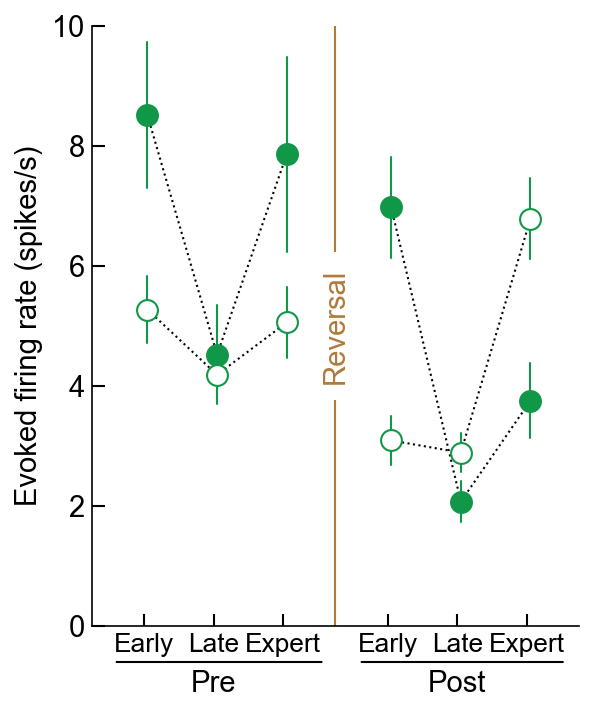

In [79]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.25
offset_distance = 0.05

################################################################################################################

data = [Tuning_target_preearly_AC,Tuning_target_prelate_AC,Tuning_target_preexpert_AC,Tuning_target_postearly_AC,Tuning_target_postlate_AC,Tuning_target_postexpert_AC]
data = [ilep.rmnan(d) for d in data]
#Plot summary
colmaxes = [np.nan]*6
for idx,(column,polarity) in enumerate(zip(data,[-1,-1,-1,1,1,1])):
    eye_color = TARGET_COLOR#PHASE_COLORS[idx]
    border_color=eye_color
    summary_size=100
    summary_width=1
    
    #Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    median = np.mean(column)
    Q1 = median - sem(column)
    Q3 = median + sem(column)
    colmaxes[idx] = Q3
    
    ax.scatter([idx+offset_distance+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+offset_distance+polarity*switch_offset, idx+offset_distance+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
medians = [np.mean(col) for col in data]
plt.plot(np.linspace(0,2,3)+offset_distance-switch_offset,medians[0:3],color='k',linestyle=':',lw=1)
plt.plot(np.linspace(3,5,3)+offset_distance+switch_offset,medians[3:6],color='k',linestyle=':',lw=1)
    
########################################################
data_two = [Tuning_target_preearly,Tuning_target_prelate,Tuning_target_preexpert,Tuning_target_postearly,Tuning_target_postlate,Tuning_target_postexpert]
data_two = [ilep.rmnan(d) for d in data_two]
#Plot summary
colmaxes = [np.nan]*6
for idx,(column,polarity) in enumerate(zip(data_two,[-1,-1,-1,1,1,1])):
    eye_color = TARGET_COLOR#PHASE_COLORS[idx]
    border_color=eye_color
    summary_size=100
    summary_width=1
    
    #Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    median = np.mean(column)
    Q1 = median - sem(column)
    Q3 = median + sem(column)
    colmaxes[idx] = Q3
    
    ax.scatter([idx+offset_distance+polarity*switch_offset], [median], ec=eye_color,fc='white', s=summary_size,lw=summary_width, zorder=10,label='M2')
    ax.plot([idx+offset_distance+polarity*switch_offset, idx+offset_distance+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
medians = [np.mean(col) for col in data_two]
plt.plot(np.linspace(0,2,3)+offset_distance-switch_offset,medians[0:3],color='k',linestyle=':',lw=1)
plt.plot(np.linspace(3,5,3)+offset_distance+switch_offset,medians[3:6],color='k',linestyle=':',lw=1)

################################################################################################################

labels = ['Early','Late','Expert','Early','Late','Expert']
# labels2 = [1,2,3,4,5,6]

ax.set_ylim([0,10])
#ax.set_yticks([4,5,6,7,8,9,10,11])
#ax.set_yticklabels([4,5,6,7,8,9,10,11])
ylab = ax.set_ylabel('Evoked firing rate (spikes/s)')
              
ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)

# ax2 = ax.twiny()
# ax2.spines['top'].set_visible(True)
# ax2.get_xaxis().set_visible(True)
# ax2.set_xlim([-0.5-switch_offset,5.5+switch_offset])
# ax2.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
# ax2.set_xticklabels(labels2)
# xlab2 = ax2.set_xlabel('Passive exposure phase')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.0425, -stdyfrac), xycoords='axes fraction', xytext=(0.48, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.545, -stdyfrac), xycoords='axes fraction', xytext=(0.975, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)
# ax2.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass
# for item in ([ax2.title, ax2.xaxis.label, ax2.yaxis.label] +
#     ax2.get_xticklabels() + ax2.get_yticklabels()):
#     item.set_fontsize(stdfont)

ax.scatter([], [], ec=TARGET_COLOR,fc=TARGET_COLOR, s=summary_size,lw=summary_width,marker='o',label='Target')
ax.scatter([], [], ec=NONTARGET_COLOR,fc=NONTARGET_COLOR, s=summary_size,lw=summary_width,marker='o',label='Nontarget')
# lgd = ax.legend(frameon=False,loc=(0.8,0.8),fontsize=14)
    
### Log
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

### Linear
Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

# artists = [ylab,t1,t2,lgd]
artists = [ylab,t1,t2]
fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Multi-region\\spon_evok\\target Evoked firing rate.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [80]:
ilep.nonparametricIndependentStatsCompareToOther(data_target,data_target_AC)
pass

            Source             SS      DF           MS          F  \
0            phase    5409.031962     5.0  1081.806392  11.512300   
1          context     603.038935     1.0   603.038935   6.417382   
2  phase * context    4072.456890     5.0   814.491378   8.667604   
3         Residual  246858.177608  2627.0    93.969615        NaN   

          p-unc       np2  
0  5.123679e-11  0.021442  
1  1.135857e-02  0.002437  
2  3.679708e-08  0.016229  
3           NaN       NaN  

          phase  A  B         p-unc    p-corr    hedges
16   post-early  A  B  2.443120e-02  0.036647 -0.336111
17  post-expert  A  B  3.224689e-07  0.000002  0.320498
18    post-late  A  B  1.372542e-05  0.000041  0.138898
19    pre-early  A  B  2.279477e-01  0.273537 -0.282391
20   pre-expert  A  B  7.108596e-01  0.710860 -0.244581
21     pre-late  A  B  1.806705e-02  0.036134 -0.038945
key preearly has 159 and 148 non-nan elements
key prelate has 239 and 187 non-nan elements
key preexpert has 183 and 97 n

In [95]:
# 0.05 = *
# 0.01 = **
# 0.001 = ***
# 0.0001 = ****

In [96]:
7.401365e-04 	

0.0007401365

In [97]:
1.106221e-04 	

0.0001106221

In [98]:
1.428699e-03

0.001428699

In [99]:
1.282697e-01

0.1282697

meta NOT subset; don't know how to subset; dropped


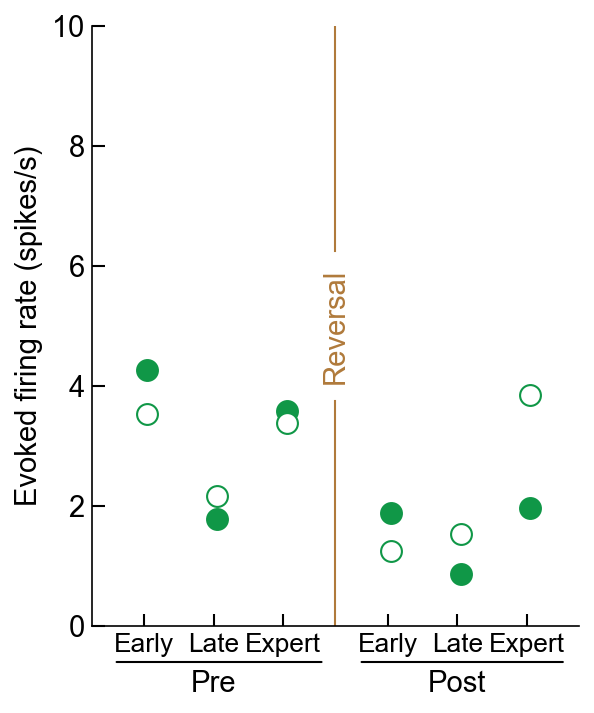

In [58]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.25
offset_distance = 0.05

################################################################################################################

data = [Tuning_target_preearly_AC,Tuning_target_prelate_AC,Tuning_target_preexpert_AC,Tuning_target_postearly_AC,Tuning_target_postlate_AC,Tuning_target_postexpert_AC]
data = [ilep.rmnan(d) for d in data]
#Plot summary
colmaxes = [np.nan]*6
for idx,(column,polarity) in enumerate(zip(data,[-1,-1,-1,1,1,1])):
    eye_color = TARGET_COLOR#PHASE_COLORS[idx]
    border_color=eye_color
    summary_size=100
    summary_width=1
    
    #Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    median = np.median(column)
    Q1 = median - sem(column)
    Q3 = median + sem(column)
    colmaxes[idx] = Q3
    
    ax.scatter([idx+offset_distance+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    #ax.plot([idx+offset_distance+polarity*switch_offset, idx+offset_distance+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
medians = [np.mean(col) for col in data]
#plt.plot(np.linspace(0,2,3)+offset_distance-switch_offset,medians[0:3],color='k',linestyle=':',lw=1)
#plt.plot(np.linspace(3,5,3)+offset_distance+switch_offset,medians[3:6],color='k',linestyle=':',lw=1)
    
########################################################
data_two = [Tuning_target_preearly,Tuning_target_prelate,Tuning_target_preexpert,Tuning_target_postearly,Tuning_target_postlate,Tuning_target_postexpert]
data_two = [ilep.rmnan(d) for d in data_two]
#Plot summary
colmaxes = [np.nan]*6
for idx,(column,polarity) in enumerate(zip(data_two,[-1,-1,-1,1,1,1])):
    eye_color = TARGET_COLOR#PHASE_COLORS[idx]
    border_color=eye_color
    summary_size=100
    summary_width=1
    
    #Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    median = np.median(column)
    Q1 = median - sem(column)
    Q3 = median + sem(column)
    colmaxes[idx] = Q3
    
    ax.scatter([idx+offset_distance+polarity*switch_offset], [median], ec=eye_color,fc='white', s=summary_size,lw=summary_width, zorder=10,label='M2')
    #ax.plot([idx+offset_distance+polarity*switch_offset, idx+offset_distance+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
medians = [np.mean(col) for col in data_two]
#plt.plot(np.linspace(0,2,3)+offset_distance-switch_offset,medians[0:3],color='k',linestyle=':',lw=1)
#plt.plot(np.linspace(3,5,3)+offset_distance+switch_offset,medians[3:6],color='k',linestyle=':',lw=1)

################################################################################################################

labels = ['Early','Late','Expert','Early','Late','Expert']
# labels2 = [1,2,3,4,5,6]

ax.set_ylim([0,10])
#ax.set_yticks([4,5,6,7,8,9,10,11])
#ax.set_yticklabels([4,5,6,7,8,9,10,11])
ylab = ax.set_ylabel('Evoked firing rate (spikes/s)')
              
ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.0425, -stdyfrac), xycoords='axes fraction', xytext=(0.48, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.545, -stdyfrac), xycoords='axes fraction', xytext=(0.975, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)
# ax2.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

ax.scatter([], [], ec=TARGET_COLOR,fc=TARGET_COLOR, s=summary_size,lw=summary_width,marker='o',label='Target')
ax.scatter([], [], ec=NONTARGET_COLOR,fc=NONTARGET_COLOR, s=summary_size,lw=summary_width,marker='o',label='Nontarget')

### Linear
Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Multi-region\\spon_evok\\M2 median target Evoked firing rate.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [107]:
pg.multicomp(target_pvals,method='fdr_bh')

(array([False,  True, False,  True,  True,  True]),
 array([2.73537240e-01, 3.61340922e-02, 7.10859631e-01, 3.66468032e-02,
        4.11762739e-05, 1.93481326e-06]))

### stats check

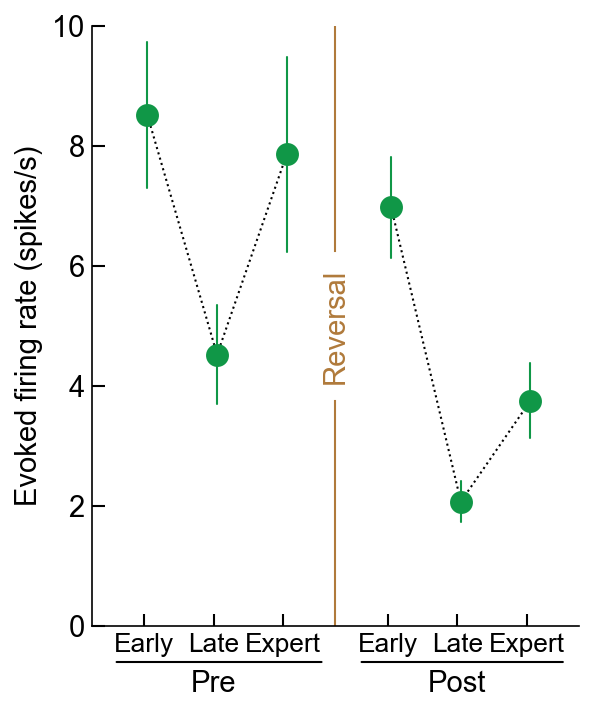

In [83]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.25
offset_distance = 0.05

################################################################################################################

data = [Tuning_target_preearly_AC,Tuning_target_prelate_AC,Tuning_target_preexpert_AC,Tuning_target_postearly_AC,Tuning_target_postlate_AC,Tuning_target_postexpert_AC]
data = [ilep.rmnan(d) for d in data]
#Plot summary
colmaxes = [np.nan]*6
for idx,(column,polarity) in enumerate(zip(data,[-1,-1,-1,1,1,1])):
    eye_color = TARGET_COLOR#PHASE_COLORS[idx]
    border_color=eye_color
    summary_size=100
    summary_width=1
    
    #Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    median = np.mean(column)
    Q1 = median - sem(column)
    Q3 = median + sem(column)
    colmaxes[idx] = Q3
    
    ax.scatter([idx+offset_distance+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+offset_distance+polarity*switch_offset, idx+offset_distance+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
medians = [np.mean(col) for col in data]
plt.plot(np.linspace(0,2,3)+offset_distance-switch_offset,medians[0:3],color='k',linestyle=':',lw=1)
plt.plot(np.linspace(3,5,3)+offset_distance+switch_offset,medians[3:6],color='k',linestyle=':',lw=1)
    
########################################################
# data_two = [Tuning_target_preearly,Tuning_target_prelate,Tuning_target_preexpert,Tuning_target_postearly,Tuning_target_postlate,Tuning_target_postexpert]
# data_two = [ilep.rmnan(d) for d in data_two]
# #Plot summary
# colmaxes = [np.nan]*6
# for idx,(column,polarity) in enumerate(zip(data_two,[-1,-1,-1,1,1,1])):
#     eye_color = TARGET_COLOR#PHASE_COLORS[idx]
#     border_color=eye_color
#     summary_size=100
#     summary_width=1
    
#     #Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
#     median = np.mean(column)
#     Q1 = median - sem(column)
#     Q3 = median + sem(column)
#     colmaxes[idx] = Q3
    
#     ax.scatter([idx+offset_distance+polarity*switch_offset], [median], ec=eye_color,fc='white', s=summary_size,lw=summary_width, zorder=10,label='M2')
#     ax.plot([idx+offset_distance+polarity*switch_offset, idx+offset_distance+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
# medians = [np.mean(col) for col in data_two]
# plt.plot(np.linspace(0,2,3)+offset_distance-switch_offset,medians[0:3],color='k',linestyle=':',lw=1)
# plt.plot(np.linspace(3,5,3)+offset_distance+switch_offset,medians[3:6],color='k',linestyle=':',lw=1)

################################################################################################################

labels = ['Early','Late','Expert','Early','Late','Expert']
# labels2 = [1,2,3,4,5,6]

ax.set_ylim([0,10])
#ax.set_yticks([4,5,6,7,8,9,10,11])
#ax.set_yticklabels([4,5,6,7,8,9,10,11])
ylab = ax.set_ylabel('Evoked firing rate (spikes/s)')
              
ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)

# ax2 = ax.twiny()
# ax2.spines['top'].set_visible(True)
# ax2.get_xaxis().set_visible(True)
# ax2.set_xlim([-0.5-switch_offset,5.5+switch_offset])
# ax2.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
# ax2.set_xticklabels(labels2)
# xlab2 = ax2.set_xlabel('Passive exposure phase')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.0425, -stdyfrac), xycoords='axes fraction', xytext=(0.48, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.545, -stdyfrac), xycoords='axes fraction', xytext=(0.975, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)
# ax2.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass
# for item in ([ax2.title, ax2.xaxis.label, ax2.yaxis.label] +
#     ax2.get_xticklabels() + ax2.get_yticklabels()):
#     item.set_fontsize(stdfont)

ax.scatter([], [], ec=TARGET_COLOR,fc=TARGET_COLOR, s=summary_size,lw=summary_width,marker='o',label='Target')
ax.scatter([], [], ec=NONTARGET_COLOR,fc=NONTARGET_COLOR, s=summary_size,lw=summary_width,marker='o',label='Nontarget')
# lgd = ax.legend(frameon=False,loc=(0.8,0.8),fontsize=14)
    
### Log
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

### Linear
Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

# artists = [ylab,t1,t2,lgd]
artists = [ylab,t1,t2]

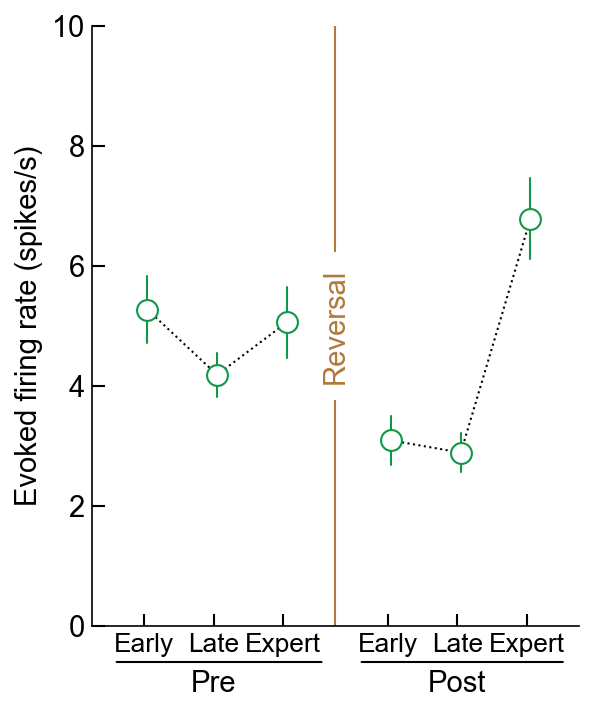

In [84]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.25
offset_distance = 0.05

################################################################################################################

# data = [Tuning_target_preearly_AC,Tuning_target_prelate_AC,Tuning_target_preexpert_AC,Tuning_target_postearly_AC,Tuning_target_postlate_AC,Tuning_target_postexpert_AC]
# data = [ilep.rmnan(d) for d in data]
# #Plot summary
# colmaxes = [np.nan]*6
# for idx,(column,polarity) in enumerate(zip(data,[-1,-1,-1,1,1,1])):
#     eye_color = TARGET_COLOR#PHASE_COLORS[idx]
#     border_color=eye_color
#     summary_size=100
#     summary_width=1
    
#     #Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
#     median = np.mean(column)
#     Q1 = median - sem(column)
#     Q3 = median + sem(column)
#     colmaxes[idx] = Q3
    
#     ax.scatter([idx+offset_distance+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
#     ax.plot([idx+offset_distance+polarity*switch_offset, idx+offset_distance+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
# medians = [np.mean(col) for col in data]
# plt.plot(np.linspace(0,2,3)+offset_distance-switch_offset,medians[0:3],color='k',linestyle=':',lw=1)
# plt.plot(np.linspace(3,5,3)+offset_distance+switch_offset,medians[3:6],color='k',linestyle=':',lw=1)
    
########################################################
data_two = [Tuning_target_preearly,Tuning_target_prelate,Tuning_target_preexpert,Tuning_target_postearly,Tuning_target_postlate,Tuning_target_postexpert]
data_two = [ilep.rmnan(d) for d in data_two]
#Plot summary
colmaxes = [np.nan]*6
for idx,(column,polarity) in enumerate(zip(data_two,[-1,-1,-1,1,1,1])):
    eye_color = TARGET_COLOR#PHASE_COLORS[idx]
    border_color=eye_color
    summary_size=100
    summary_width=1
    
    #Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    median = np.mean(column)
    Q1 = median - sem(column)
    Q3 = median + sem(column)
    colmaxes[idx] = Q3
    
    ax.scatter([idx+offset_distance+polarity*switch_offset], [median], ec=eye_color,fc='white', s=summary_size,lw=summary_width, zorder=10,label='M2')
    ax.plot([idx+offset_distance+polarity*switch_offset, idx+offset_distance+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
medians = [np.mean(col) for col in data_two]
plt.plot(np.linspace(0,2,3)+offset_distance-switch_offset,medians[0:3],color='k',linestyle=':',lw=1)
plt.plot(np.linspace(3,5,3)+offset_distance+switch_offset,medians[3:6],color='k',linestyle=':',lw=1)

################################################################################################################

labels = ['Early','Late','Expert','Early','Late','Expert']
# labels2 = [1,2,3,4,5,6]

ax.set_ylim([0,10])
#ax.set_yticks([4,5,6,7,8,9,10,11])
#ax.set_yticklabels([4,5,6,7,8,9,10,11])
ylab = ax.set_ylabel('Evoked firing rate (spikes/s)')
              
ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)

# ax2 = ax.twiny()
# ax2.spines['top'].set_visible(True)
# ax2.get_xaxis().set_visible(True)
# ax2.set_xlim([-0.5-switch_offset,5.5+switch_offset])
# ax2.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
# ax2.set_xticklabels(labels2)
# xlab2 = ax2.set_xlabel('Passive exposure phase')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.0425, -stdyfrac), xycoords='axes fraction', xytext=(0.48, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.545, -stdyfrac), xycoords='axes fraction', xytext=(0.975, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)
# ax2.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass
# for item in ([ax2.title, ax2.xaxis.label, ax2.yaxis.label] +
#     ax2.get_xticklabels() + ax2.get_yticklabels()):
#     item.set_fontsize(stdfont)

ax.scatter([], [], ec=TARGET_COLOR,fc=TARGET_COLOR, s=summary_size,lw=summary_width,marker='o',label='Target')
ax.scatter([], [], ec=NONTARGET_COLOR,fc=NONTARGET_COLOR, s=summary_size,lw=summary_width,marker='o',label='Nontarget')
# lgd = ax.legend(frameon=False,loc=(0.8,0.8),fontsize=14)
    
### Log
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

### Linear
Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

# artists = [ylab,t1,t2,lgd]
artists = [ylab,t1,t2]

ValueError: x and y must have same first dimension, but have shapes (3,) and (2,)

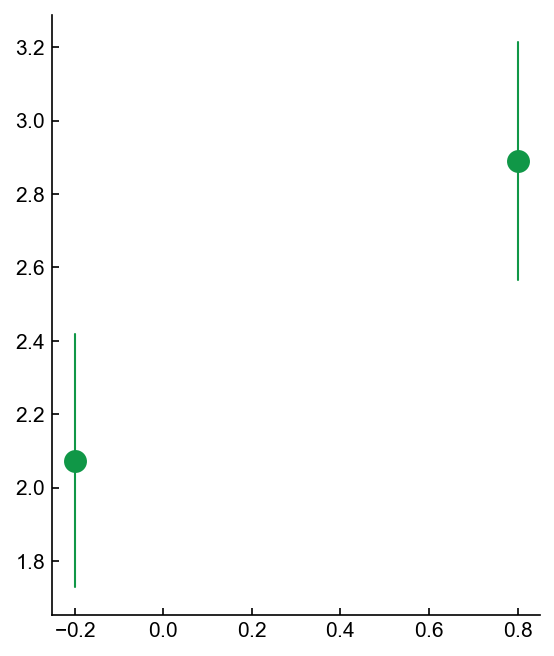

In [85]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.25
offset_distance = 0.05

################################################################################################################

data = [Tuning_target_postlate_AC,Tuning_target_postlate]
data = [ilep.rmnan(d) for d in data]
#Plot summary
colmaxes = [np.nan]*6
for idx,(column,polarity) in enumerate(zip(data,[-1,-1,-1,1,1,1])):
    eye_color = TARGET_COLOR#PHASE_COLORS[idx]
    border_color=eye_color
    summary_size=100
    summary_width=1
    
    #Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    median = np.mean(column)
    Q1 = median - sem(column)
    Q3 = median + sem(column)
    colmaxes[idx] = Q3
    
    ax.scatter([idx+offset_distance+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+offset_distance+polarity*switch_offset, idx+offset_distance+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
medians = [np.mean(col) for col in data]
plt.plot(np.linspace(0,2,3)+offset_distance-switch_offset,medians[0:3],color='k',linestyle=':',lw=1)
plt.plot(np.linspace(3,5,3)+offset_distance+switch_offset,medians[3:6],color='k',linestyle=':',lw=1)
    
########################################################
# data_two = [Tuning_target_preearly,Tuning_target_prelate,Tuning_target_preexpert,Tuning_target_postearly,Tuning_target_postlate,Tuning_target_postexpert]
# data_two = [ilep.rmnan(d) for d in data_two]
# #Plot summary
# colmaxes = [np.nan]*6
# for idx,(column,polarity) in enumerate(zip(data_two,[-1,-1,-1,1,1,1])):
#     eye_color = TARGET_COLOR#PHASE_COLORS[idx]
#     border_color=eye_color
#     summary_size=100
#     summary_width=1
    
#     #Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
#     median = np.mean(column)
#     Q1 = median - sem(column)
#     Q3 = median + sem(column)
#     colmaxes[idx] = Q3
    
#     ax.scatter([idx+offset_distance+polarity*switch_offset], [median], ec=eye_color,fc='white', s=summary_size,lw=summary_width, zorder=10,label='M2')
#     ax.plot([idx+offset_distance+polarity*switch_offset, idx+offset_distance+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
# medians = [np.mean(col) for col in data_two]
# plt.plot(np.linspace(0,2,3)+offset_distance-switch_offset,medians[0:3],color='k',linestyle=':',lw=1)
# plt.plot(np.linspace(3,5,3)+offset_distance+switch_offset,medians[3:6],color='k',linestyle=':',lw=1)

################################################################################################################

labels = ['Early','Late','Expert','Early','Late','Expert']
# labels2 = [1,2,3,4,5,6]

ax.set_ylim([0,10])
#ax.set_yticks([4,5,6,7,8,9,10,11])
#ax.set_yticklabels([4,5,6,7,8,9,10,11])
ylab = ax.set_ylabel('Evoked firing rate (spikes/s)')
              
ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)

# ax2 = ax.twiny()
# ax2.spines['top'].set_visible(True)
# ax2.get_xaxis().set_visible(True)
# ax2.set_xlim([-0.5-switch_offset,5.5+switch_offset])
# ax2.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
# ax2.set_xticklabels(labels2)
# xlab2 = ax2.set_xlabel('Passive exposure phase')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.0425, -stdyfrac), xycoords='axes fraction', xytext=(0.48, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.545, -stdyfrac), xycoords='axes fraction', xytext=(0.975, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)
# ax2.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass
# for item in ([ax2.title, ax2.xaxis.label, ax2.yaxis.label] +
#     ax2.get_xticklabels() + ax2.get_yticklabels()):
#     item.set_fontsize(stdfont)

ax.scatter([], [], ec=TARGET_COLOR,fc=TARGET_COLOR, s=summary_size,lw=summary_width,marker='o',label='Target')
ax.scatter([], [], ec=NONTARGET_COLOR,fc=NONTARGET_COLOR, s=summary_size,lw=summary_width,marker='o',label='Nontarget')
# lgd = ax.legend(frameon=False,loc=(0.8,0.8),fontsize=14)
    
### Log
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

### Linear
Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

# artists = [ylab,t1,t2,lgd]
artists = [ylab,t1,t2]

In [86]:
[Tuning_target_postlate_AC,Tuning_target_postlate]

[array([ 0.8168643 , -1.9047619 ,  0.89591568,  1.18577075,  2.02898551,
         5.085639  ,  1.81818182,  1.50234742,  0.77071291,  2.20338983,
        -1.08036891,  0.92226614,  1.84453228, -3.27345309, -6.59313725,
        -3.94736842,  1.93548387, -1.44607843,  5.51470588, -2.25490196,
        -1.51041667, -1.93627451, -3.57843137,  2.72058824, -2.57352941,
        -1.29901961, -1.8872549 ,  1.74019608, -0.58823529, -1.17647059,
         1.38211382,  3.1372549 , -1.51960784,  0.49382716,  0.7183908 ,
        -6.61764706, -2.72058824,  5.49019608, -0.85784314,  2.23039216,
         3.94607843,  1.69117647, -4.56410256,  1.96078431,  3.27272727,
        -1.94174757, -1.30879346, -3.13075506, -6.97435897, -3.84615385,
         0.99585062, -0.63180828, -3.74727669,  0.76923077,  2.44008715,
        -1.29963899,  1.75555556, -2.34042553,  3.47381865,  1.01694915,
         2.37247924,  1.66666667,  1.51111111, -1.51111111, -4.49223417,
        -3.28808446, -1.2       ,  5.42222222, -0.7

In [87]:
import scipy
scipy.stats.mannwhitneyu(Tuning_target_postlate_AC,Tuning_target_postlate)


MannwhitneyuResult(statistic=33375.0, pvalue=1.3725424624175373e-05)

In [88]:
len(Tuning_target_postlate_AC)

342

In [89]:
len(Tuning_target_postlate)

247

In [90]:
a = np.random.choice(Tuning_target_postlate_AC,100)

In [91]:
b = np.random.choice(Tuning_target_postlate,100)

In [92]:
import scipy
scipy.stats.mannwhitneyu(a,b)


MannwhitneyuResult(statistic=3766.0, pvalue=0.002578552875349499)

meta NOT subset; don't know how to subset; dropped


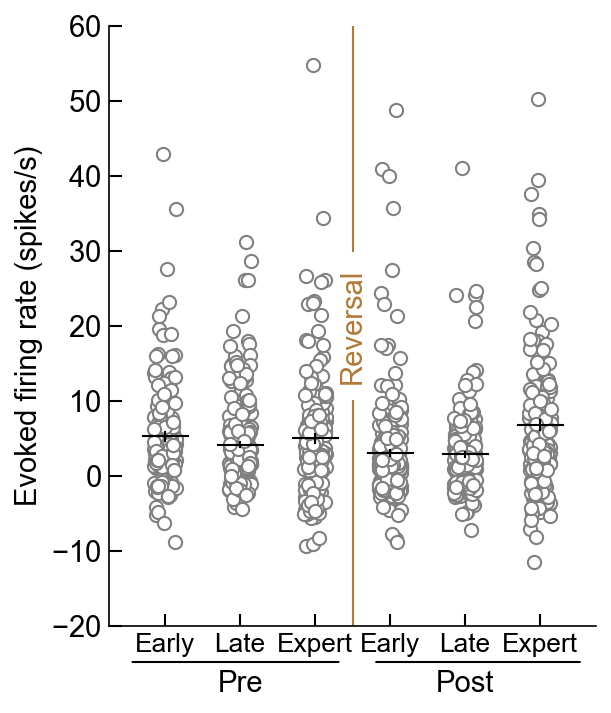

In [93]:
#M2
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)

switch_offset = 0
width = 0.3
################################################################################################################

#Plot figure 
data = [Tuning_target_preearly,Tuning_target_prelate,Tuning_target_preexpert,Tuning_target_postearly,Tuning_target_postlate,Tuning_target_postexpert]
PHASE_COLORS = ['#E2CAE3','#C27AC5','#764979','#B9D3F7','#5181C2','#3C557A']

#Plot summary
for idx,column in enumerate(data):
    Y = ilep.rmnan(column)
    X = np.random.uniform(-width/2,width/2,size=len(Y)) + idx
    
    
    mean = np.mean(Y)
    SEM = sem(Y)

    ax.scatter(X-switch_offset,Y,s=40,edgecolor=CR_COLOR,color='white')
        
    ax.plot([idx-switch_offset-width,idx-switch_offset+width],[mean]*2,color='k',lw=1, clip_on = False)
    ax.plot([idx-switch_offset]*2,[mean-SEM,mean+SEM],color='k',lw=1, clip_on = False)



################################################################################################################

labels = ['Early','Late','Expert','Early','Late','Expert']

ax.set_ylim([-20,60])
#ax.set_ylim([0,10])
#ax.set_yticks([0,100,200,300,400,500])
#ax.set_yticklabels(['0','100','200','300','400','500'])
ylab = ax.set_ylabel('Evoked firing rate (spikes/s)')

ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.04, -stdyfrac), xycoords='axes fraction', xytext=(0.48, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.54, -stdyfrac), xycoords='axes fraction', xytext=(0.975, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

### Log
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

### Linear
Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Multi-region\\spon_evok\\M2 Evoked firing rate (stats analysis).pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

meta NOT subset; don't know how to subset; dropped


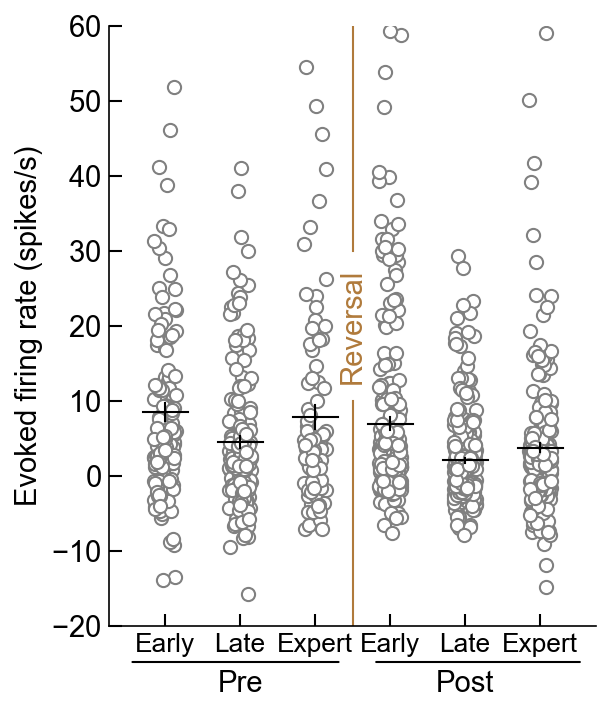

In [94]:
#AC
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)

switch_offset = 0
width = 0.3
################################################################################################################

#Plot figure 
data = [Tuning_target_preearly_AC,Tuning_target_prelate_AC,Tuning_target_preexpert_AC,Tuning_target_postearly_AC,Tuning_target_postlate_AC,Tuning_target_postexpert_AC]
PHASE_COLORS = ['#E2CAE3','#C27AC5','#764979','#B9D3F7','#5181C2','#3C557A']

#Plot summary
for idx,column in enumerate(data):
    Y = ilep.rmnan(column)
    X = np.random.uniform(-width/2,width/2,size=len(Y)) + idx
    
    
    mean = np.mean(Y)
    SEM = sem(Y)

    ax.scatter(X-switch_offset,Y,s=40,edgecolor=CR_COLOR,color='white')
        
    ax.plot([idx-switch_offset-width,idx-switch_offset+width],[mean]*2,color='k',lw=1, clip_on = False)
    ax.plot([idx-switch_offset]*2,[mean-SEM,mean+SEM],color='k',lw=1, clip_on = False)



################################################################################################################

labels = ['Early','Late','Expert','Early','Late','Expert']

ax.set_ylim([-20,60])
#ax.set_ylim([0,10])
#ax.set_yticks([0,100,200,300,400,500])
#ax.set_yticklabels(['0','100','200','300','400','500'])
ylab = ax.set_ylabel('Evoked firing rate (spikes/s)')

ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.04, -stdyfrac), xycoords='axes fraction', xytext=(0.48, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.54, -stdyfrac), xycoords='axes fraction', xytext=(0.975, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

### Log
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

### Linear
Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Multi-region\\spon_evok\\AC Evoked firing rate (stats analysis).pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [95]:
len(Tuning_target_postlate_AC)

342

In [96]:
len(Tuning_target_postlate_AC[Tuning_target_postlate_AC>15])

15

In [97]:
15/342

0.043859649122807015

In [98]:
len(Tuning_target_postlate[Tuning_target_postlate>15])

6

In [99]:
len(Tuning_target_postlate)

247

In [100]:
6/247

0.024291497975708502

In [101]:
a = Tuning_target_postlate[Tuning_target_postlate<20]

In [102]:
scipy.stats.mannwhitneyu(a,Tuning_target_postlate_AC)

MannwhitneyuResult(statistic=49069.0, pvalue=8.735901227861924e-05)

In [103]:
scipy.stats.mannwhitneyu(Tuning_target_prelate_AC,Tuning_target_prelate)

MannwhitneyuResult(statistic=19364.5, pvalue=0.01806704609593305)

In [106]:
scipy.stats.mannwhitneyu(Tuning_nontarget_preearly_AC,Tuning_nontarget_preearly)

MannwhitneyuResult(statistic=11445.0, pvalue=0.6800491493232508)

meta NOT subset; don't know how to subset; dropped


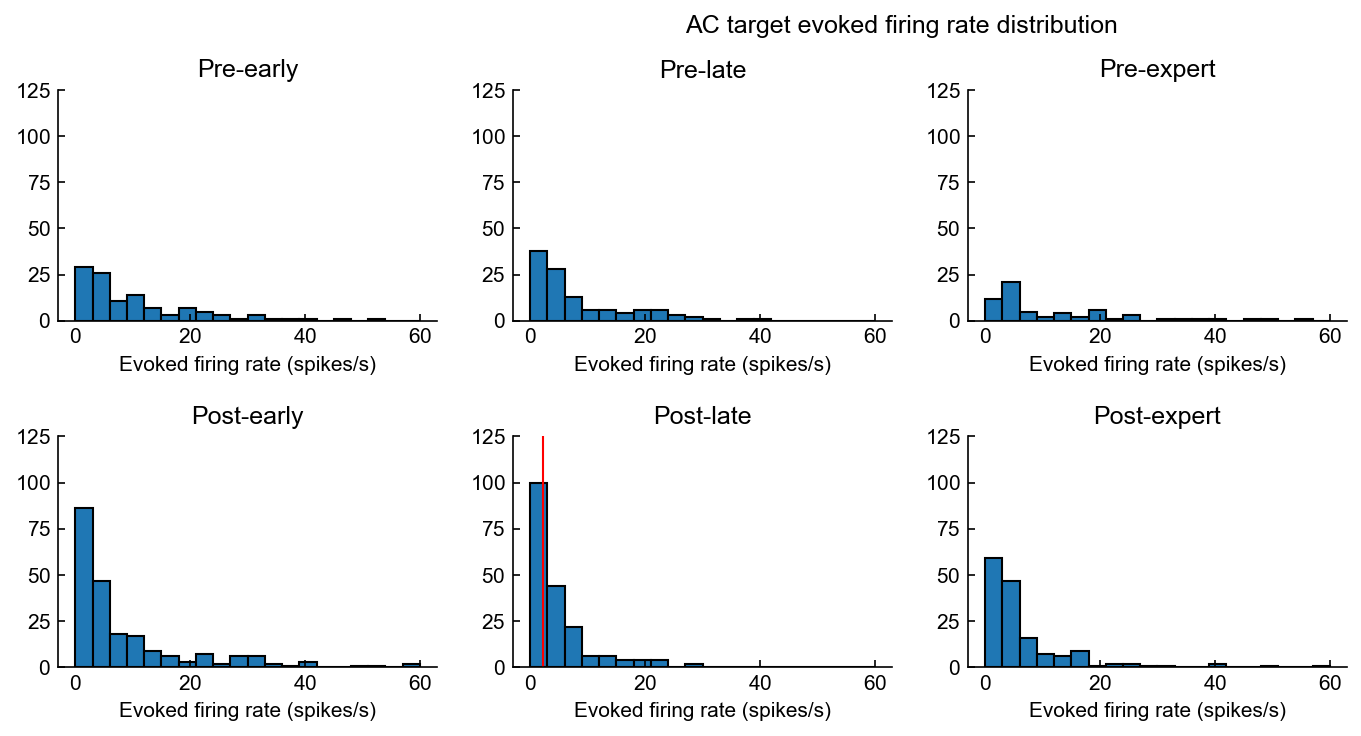

In [104]:
fig = plt.figure(figsize=(15,5))
gs = fig.add_gridspec(2,4,height_ratios=[0.4,0.4],hspace=0.5)
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1],sharex = ax1,sharey = ax1)
ax3 = plt.subplot(gs[0,2],sharex = ax1,sharey = ax1)
ax4 = plt.subplot(gs[1,0],sharex = ax1,sharey = ax1)
ax5 = plt.subplot(gs[1,1],sharex = ax1,sharey = ax1)
ax6 = plt.subplot(gs[1,2],sharex = ax1,sharey = ax1)

ax1.set_ylim(0,125)
# ax1.set_xlim(0,200)
# ax1.set_xticks([0,50,100,150,200])

ax1.set_xlabel('Evoked firing rate (spikes/s)')
ax2.set_xlabel('Evoked firing rate (spikes/s)')
ax3.set_xlabel('Evoked firing rate (spikes/s)')
ax4.set_xlabel('Evoked firing rate (spikes/s)')
ax5.set_xlabel('Evoked firing rate (spikes/s)')
ax6.set_xlabel('Evoked firing rate (spikes/s)')

ax1.hist(Tuning_target_preearly_AC,bins=20,range=(0,60),edgecolor='k')
ax2.hist(Tuning_target_prelate_AC,bins=20,range=(0,60),edgecolor='k')
ax3.hist(Tuning_target_preexpert_AC,bins=20,range=(0,60),edgecolor='k')
ax4.hist(Tuning_target_postearly_AC,bins=20,range=(0,60),edgecolor='k')
ax5.hist(Tuning_target_postlate_AC,bins=20,range=(0,60),edgecolor='k')
ax6.hist(Tuning_target_postexpert_AC,bins=20,range=(0,60),edgecolor='k')

ax1.set_title('Pre-early')
ax2.set_title('Pre-late')
ax3.set_title('Pre-expert')
ax4.set_title('Post-early')
ax5.set_title('Post-late')
ax6.set_title('Post-expert')
plt.suptitle('AC target evoked firing rate distribution')

median = np.median(Tuning_target_postlate)
ax5.axvline(median,100,0,color='red',lw=1)

fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Multi-region\\spon_evok\\Post late analysis\\AC target distribution.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

meta NOT subset; don't know how to subset; dropped


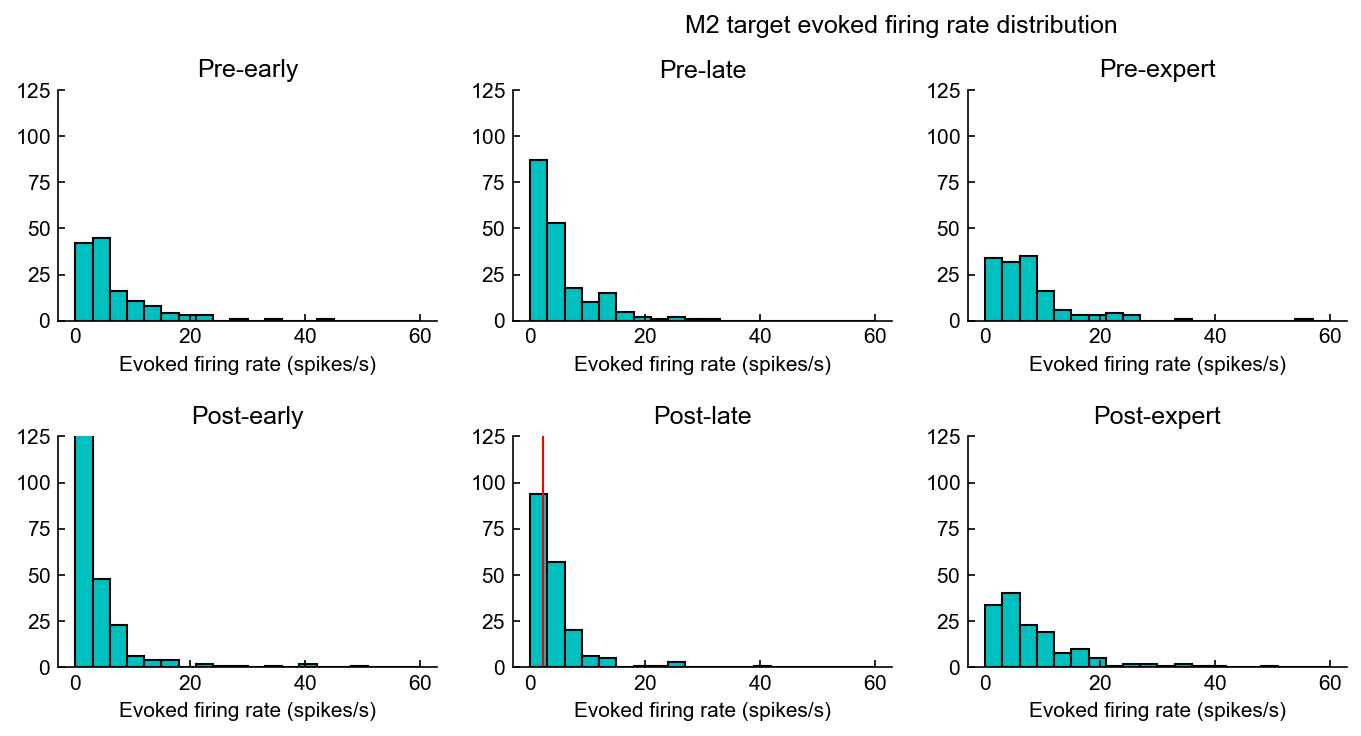

In [105]:
fig = plt.figure(figsize=(15,5))
gs = fig.add_gridspec(2,4,height_ratios=[0.4,0.4],hspace=0.5)
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1],sharex = ax1,sharey = ax1)
ax3 = plt.subplot(gs[0,2],sharex = ax1,sharey = ax1)
ax4 = plt.subplot(gs[1,0],sharex = ax1,sharey = ax1)
ax5 = plt.subplot(gs[1,1],sharex = ax1,sharey = ax1)
ax6 = plt.subplot(gs[1,2],sharex = ax1,sharey = ax1)

ax1.set_ylim(0,125)
# ax1.set_xlim(0,200)
# ax1.set_xticks([0,50,100,150,200])

ax1.set_xlabel('Evoked firing rate (spikes/s)')
ax2.set_xlabel('Evoked firing rate (spikes/s)')
ax3.set_xlabel('Evoked firing rate (spikes/s)')
ax4.set_xlabel('Evoked firing rate (spikes/s)')
ax5.set_xlabel('Evoked firing rate (spikes/s)')
ax6.set_xlabel('Evoked firing rate (spikes/s)')

ax1.hist(Tuning_target_preearly,bins=20,range=(0,60),color='c',edgecolor='k')
ax2.hist(Tuning_target_prelate,bins=20,range=(0,60),color='c',edgecolor='k')
ax3.hist(Tuning_target_preexpert,bins=20,range=(0,60),color='c',edgecolor='k')
ax4.hist(Tuning_target_postearly,bins=20,range=(0,60),color='c',edgecolor='k')
ax5.hist(Tuning_target_postlate,bins=20,range=(0,60),color='c',edgecolor='k')
ax6.hist(Tuning_target_postexpert,bins=20,range=(0,60),color='c',edgecolor='k')

ax1.set_title('Pre-early')
ax2.set_title('Pre-late')
ax3.set_title('Pre-expert')
ax4.set_title('Post-early')
ax5.set_title('Post-late')
ax6.set_title('Post-expert')
plt.suptitle('M2 target evoked firing rate distribution')

median = np.median(Tuning_target_postlate)
ax5.axvline(median,100,0,color='red',lw=1)

fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Multi-region\\spon_evok\\Post late analysis\\M2 target distribution.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

### nontarget

meta NOT subset; don't know how to subset; dropped


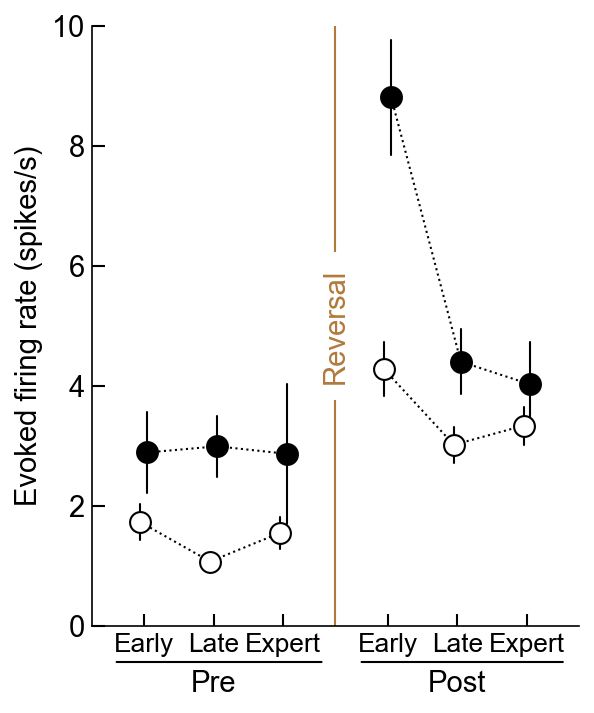

In [81]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.25
offset_distance = 0.05

################################################################################################################

data = [Tuning_nontarget_preearly_AC,Tuning_nontarget_prelate_AC,Tuning_nontarget_preexpert_AC,Tuning_nontarget_postearly_AC,Tuning_nontarget_postlate_AC,Tuning_nontarget_postexpert_AC]
data = [ilep.rmnan(d) for d in data]
#Plot summary
colmaxes = [np.nan]*6
for idx,(column,polarity) in enumerate(zip(data,[-1,-1,-1,1,1,1])):
    eye_color = NONTARGET_COLOR#PHASE_COLORS[idx]
    border_color=eye_color
    summary_size=100
    summary_width=1
    
    #Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    median = np.mean(column)
    Q1 = median - sem(column)
    Q3 = median + sem(column)
    colmaxes[idx] = Q3
    
    ax.scatter([idx+offset_distance+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+offset_distance+polarity*switch_offset, idx+offset_distance+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
medians = [np.mean(col) for col in data]
plt.plot(np.linspace(0,2,3)+offset_distance-switch_offset,medians[0:3],color='k',linestyle=':',lw=1)
plt.plot(np.linspace(3,5,3)+offset_distance+switch_offset,medians[3:6],color='k',linestyle=':',lw=1)
    
########################################################
data_two = [Tuning_nontarget_preearly,Tuning_nontarget_prelate,Tuning_nontarget_preexpert,Tuning_nontarget_postearly,Tuning_nontarget_postlate,Tuning_nontarget_postexpert]
data_two = [ilep.rmnan(d) for d in data_two]

#Plot summary
passive_colmaxes = [np.nan]*6
for idx,(column,polarity) in enumerate(zip(data_two,[-1,-1,-1,1,1,1])):
    border_color=NONTARGET_COLOR#PHASE_COLORS[idx]
    eye_color=border_color#'white'

    summary_size=100
    summary_width=1
    
    #Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    median = np.mean(column)
    Q1 = median - sem(column)
    Q3 = median + sem(column)
    passive_colmaxes[idx] = Q3
    
    ax.scatter([idx-offset_distance+polarity*switch_offset], [median], ec=eye_color,fc='white', s=summary_size,lw=summary_width, zorder=10,label='M2')
    ax.plot([idx-offset_distance+polarity*switch_offset, idx-offset_distance+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
medians = [np.mean(col) for col in data_two]
plt.plot(np.linspace(0,2,3)-offset_distance-switch_offset,medians[0:3],color='k',linestyle=':',lw=1)
plt.plot(np.linspace(3,5,3)-offset_distance+switch_offset,medians[3:6],color='k',linestyle=':',lw=1)

################################################################################################################

labels = ['Early','Late','Expert','Early','Late','Expert']
# labels2 = [1,2,3,4,5,6]

ax.set_ylim([0,10])
#ax.set_yticks([4,5,6,7,8,9,10,11])
#ax.set_yticklabels([4,5,6,7,8,9,10,11])
ylab = ax.set_ylabel('Evoked firing rate (spikes/s)')
              
ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)

# ax2 = ax.twiny()
# ax2.spines['top'].set_visible(True)
# ax2.get_xaxis().set_visible(True)
# ax2.set_xlim([-0.5-switch_offset,5.5+switch_offset])
# ax2.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
# ax2.set_xticklabels(labels2)
# xlab2 = ax2.set_xlabel('Passive exposure phase')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.0425, -stdyfrac), xycoords='axes fraction', xytext=(0.48, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.545, -stdyfrac), xycoords='axes fraction', xytext=(0.975, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)
# ax2.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass
# for item in ([ax2.title, ax2.xaxis.label, ax2.yaxis.label] +
#     ax2.get_xticklabels() + ax2.get_yticklabels()):
#     item.set_fontsize(stdfont)

ax.scatter([], [], ec=TARGET_COLOR,fc=TARGET_COLOR, s=summary_size,lw=summary_width,marker='o',label='Target')
ax.scatter([], [], ec=NONTARGET_COLOR,fc=NONTARGET_COLOR, s=summary_size,lw=summary_width,marker='o',label='Nontarget')
# lgd = ax.legend(frameon=False,loc=(0.8,0.8),fontsize=14)
    
### Log
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

### Linear
Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

# artists = [ylab,t1,t2,lgd]
artists = [ylab,t1,t2]
fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Multi-region\\spon_evok\\nontarget Evoked firing rate.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [82]:
ilep.nonparametricIndependentStatsCompareToOther(data_nontarget,data_nontarget_AC)
pass

            Source             SS      DF           MS          F  \
0            phase    7202.892293     5.0  1440.578459  17.686213   
1          context    2772.104428     1.0  2772.104428  34.033571   
2  phase * context    1294.443389     5.0   258.888678   3.178418   
3         Residual  213730.199396  2624.0    81.452058        NaN   

          p-unc       np2  
0  2.833413e-17  0.032602  
1  6.081833e-09  0.012804  
2  7.275908e-03  0.006020  
3           NaN       NaN  

          phase  A  B     p-unc    p-corr    hedges
16   post-early  A  B  0.010288  0.022054 -0.346109
17  post-expert  A  B  0.004394  0.022054 -0.077711
18    post-late  A  B  0.039035  0.058552 -0.168779
19    pre-early  A  B  0.680049  0.727665 -0.183852
20   pre-expert  A  B  0.727665  0.727665 -0.178519
21     pre-late  A  B  0.011027  0.022054 -0.393917
key preearly has 159 and 148 non-nan elements
key prelate has 238 and 187 non-nan elements
key preexpert has 182 and 97 non-nan elements
key postearl

In [102]:
# 0.05 = *
# 0.01 = **
# 0.001 = ***
# 0.0001 = ****

In [103]:
8.760088e-06 < 0.0001

True

In [104]:
7.059904e-01

0.7059904

In [105]:
1.977726e-03 

0.001977726

In [106]:
1.063649e-03

0.001063649

In [107]:
8.145539e-04

0.0008145539

# Stats

In [ ]:
FRbData = SimpleNamespace()
FRbData.preearly = FRb_preearly
FRbData.prelate = FRb_prelate
FRbData.preexpert = FRb_preexpert
FRbData.postearly = FRb_postearly
FRbData.postlate = FRb_postlate
FRbData.postexpert = FRb_postexpert
ilep.nonparametricIndependentStatsCompareToPrevious(FRbData)

In [ ]:
# 0.05 = *
# 0.01 = **
# 0.001 = ***
# 0.0001 = ****

In [ ]:
FReData = SimpleNamespace()
FReData.preearly = FRe_preearly
FReData.prelate = FRe_prelate
FReData.preexpert = FRe_preexpert
FReData.postearly = FRe_postearly
FReData.postlate = FRe_postlate
FReData.postexpert = FRe_postexpert
ilep.nonparametricIndependentStatsCompareToPrevious(FReData)

In [ ]:
FRetData = SimpleNamespace()
FRetData.preearly = FRet_preearly
FRetData.prelate = FRet_prelate
FRetData.preexpert = FRet_preexpert
FRetData.postearly = FRet_postearly
FRetData.postlate = FRet_postlate
FRetData.postexpert = FRet_postexpert
ilep.nonparametricIndependentStatsCompareToPrevious(FRetData)

In [ ]:
FRentData = SimpleNamespace()
FRentData.preearly = FRent_preearly
FRentData.prelate = FRent_prelate
FRentData.preexpert = FRent_preexpert
FRentData.postearly = FRent_postearly
FRentData.postlate = FRent_postlate
FRentData.postexpert = FRent_postexpert
ilep.nonparametricIndependentStatsCompareToPrevious(FRentData)

In [ ]:
ilep.nonparametricIndependentStatsCompareToOther(FRetData,FRentData)